In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
#pd.set_option('precision',3)

# Importing Power Generation & Weather Sensor Data

In [3]:
generation_data = pd.read_csv("Plant_1_Generation_Data.csv")

In [4]:
generation_data.sample(5).style.set_properties(
    **{
        'background-color': 'OliveDrab',
        'color': 'white',
        'border-color': 'darkblack'
    })

In [5]:
weather_data = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")

In [6]:
weather_data.sample(5).style.set_properties(
    **{
        'background-color': 'pink',
        'color': 'Black',
        'border-color': 'darkblack'
    })

# Adjust Datetime format

In [7]:
def parse_datetime(date_str):
    for fmt in ('%Y-%m-%d %H:%M', '%Y-%m-%d %H:%M:%S', '%d-%m-%Y %H:%M', '%d-%m-%Y %H:%M:%S'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    raise ValueError(f"No valid date format found for {date_str}")

generation_data['DATE_TIME'] = generation_data['DATE_TIME'].apply(parse_datetime)
weather_data['DATE_TIME'] = weather_data['DATE_TIME'].apply(parse_datetime)

generation_data['DATE_TIME'] = generation_data['DATE_TIME'].dt.strftime('%Y-%m-%d %H:%M')
weather_data['DATE_TIME'] = weather_data['DATE_TIME'].dt.strftime('%Y-%m-%d %H:%M:%S')



In [8]:
generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'],format = '%Y-%m-%d %H:%M')
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')

# Merge the weather and sensor data

In [9]:
df_solar = pd.merge(generation_data.drop(columns = ['PLANT_ID']), weather_data.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df_solar.sample(5).style.background_gradient(cmap='cool')

## Observation: A huge amount of power is getting lost at the inverters. Only 1/10th of DC Power is getting converted to AC Power.

# Separate time and date columns

In [10]:
# adding separate time and date columns
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.week


In [11]:
# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60


In [12]:
# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.head(2)

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION        DATE      TIME  \
0            25.184316           22.857507          0.0  2020-05-15  00:00:00   
1            25.184316           22.857507          0.0  2020-05-15  00:00:00   

   DAY  MONTH  WEEK HOURS  MINUTES  TOTAL MINUTES PASS DATE_STRING  
0   15      5    20     0        0                   0  2020-05-15  
1   15      5    20     0        0                   0  2020-05-15

In [13]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68774 entries, 0 to 68773
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68774 non-null  datetime64[ns]
 1   SOURCE_KEY           68774 non-null  object        
 2   DC_POWER             68774 non-null  float64       
 3   AC_POWER             68774 non-null  float64       
 4   DAILY_YIELD          68774 non-null  float64       
 5   TOTAL_YIELD          68774 non-null  float64       
 6   AMBIENT_TEMPERATURE  68774 non-null  float64       
 7   MODULE_TEMPERATURE   68774 non-null  float64       
 8   IRRADIATION          68774 non-null  float64       
 9   DATE                 68774 non-null  object        
 10  TIME                 68774 non-null  object        
 11  DAY                  68774 non-null  int64         
 12  MONTH                68774 non-null  int64         
 13  WEEK                 68774 non-

In [14]:
df_solar.isnull().sum()

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DATE                   0
TIME                   0
DAY                    0
MONTH                  0
WEEK                   0
HOURS                  0
MINUTES                0
TOTAL MINUTES PASS     0
DATE_STRING            0
dtype: int64

In [15]:
df_solar.shape

(68774, 18)

In [16]:
# there are no nulls or blank values in the dataset

In [17]:
df_solar.describe().style.background_gradient(cmap='rainbow')

# Converting 'SOURCE_KEY' from categorical form to numerical form

In [18]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#df_solar['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_solar['SOURCE_KEY'])
#df_solar.head()
#df_solar

In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode the entire column first
encoded_values = encoder.fit_transform(df_solar['SOURCE_KEY'])

# Initialize the new column with default values
df_solar['SOURCE_KEY_NUMBER'] = -1

# Process data in chunks
chunk_size = 10000  # Define a chunk size
num_chunks = (len(df_solar) // chunk_size) + 1

for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size
    if end > len(df_solar):  # Ensure the last chunk does not exceed the length
        end = len(df_solar)
    df_solar.iloc[start:end, df_solar.columns.get_loc('SOURCE_KEY_NUMBER')] = encoded_values[start:end]

print(df_solar.head())


   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION        DATE      TIME  \
0            25.184316           22.857507          0.0  2020-05-15  00:00:00   
1            25.184316           22.857507          0.0  2020-05-15  00:00:00   
2            25.184316           22.857507          0.0  2020-05-15  00:00:00   
3            25.184316           22.857507          0.0  2020-05-15  00:00:00   
4            25.184316           22.857507          0.0  2020-05-15  00:00:00   

   DAY  MONTH  WEEK HOURS  MINUTES  TO

In [20]:
file_name = 'df_solar.csv'
df_solar.to_csv(file_name, index=False)

# Data Visualization

In [21]:
df_solar['DATE'].nunique() #the data is daily for 34 days

34

## 1. DC & AC Power plots over all 34 days

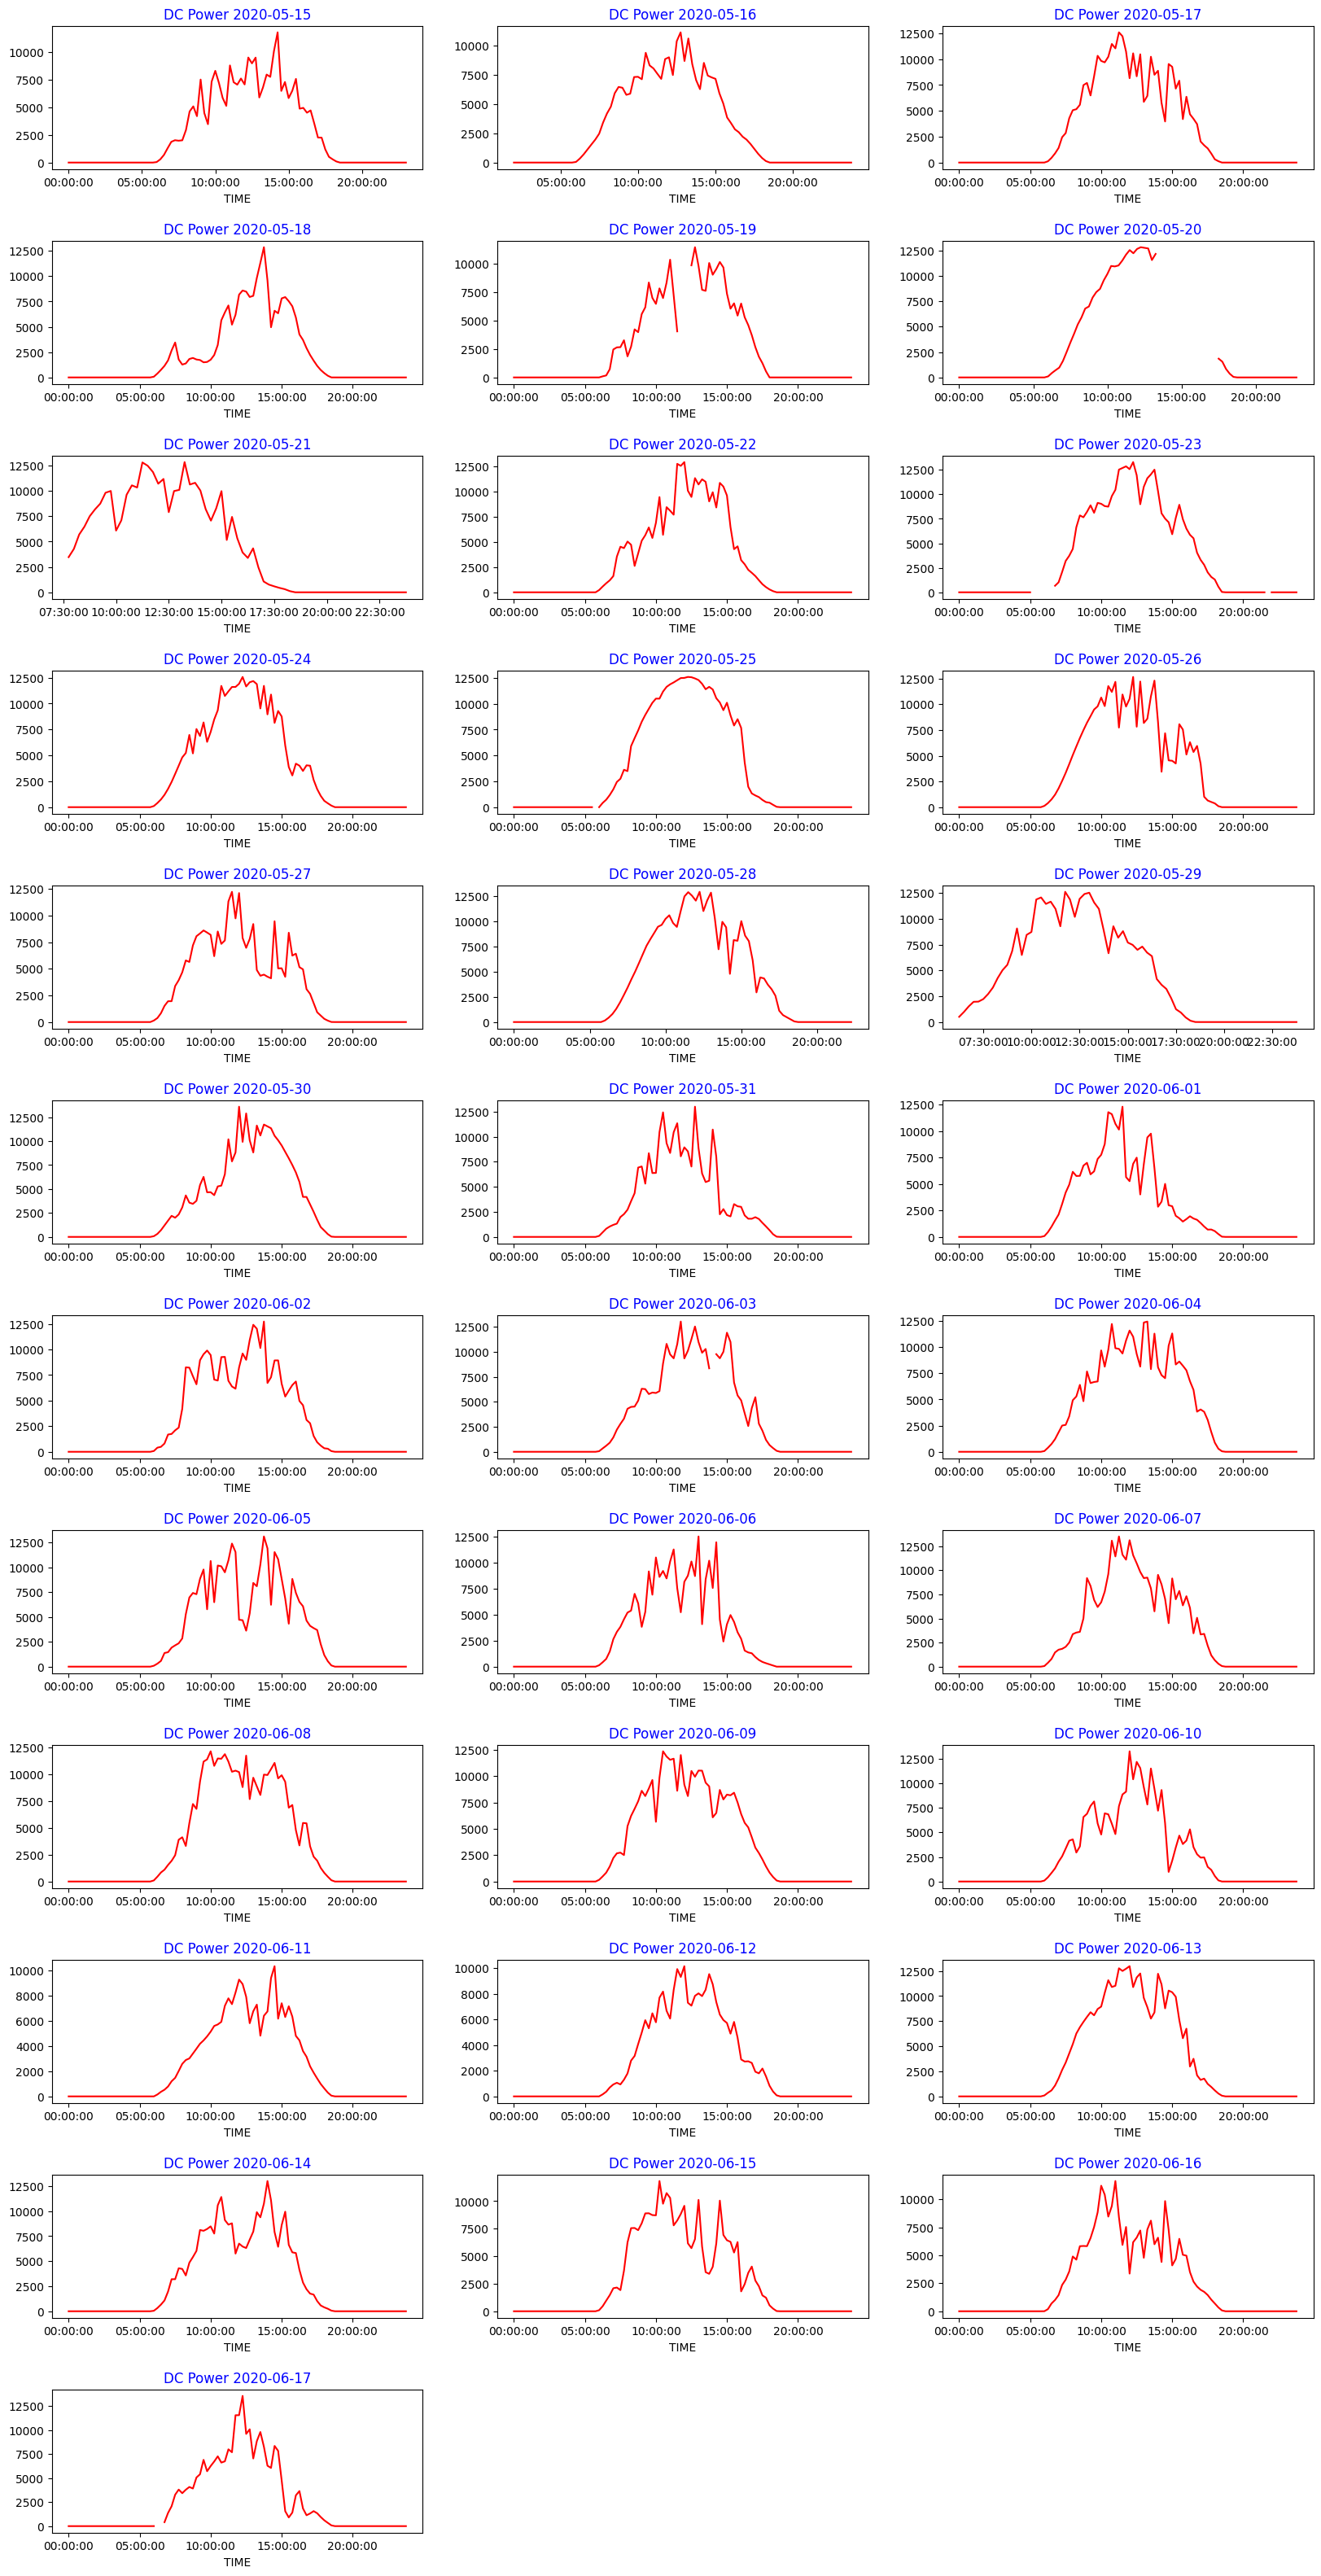

In [22]:
solar_dc = df_solar.pivot_table(values='DC_POWER', index='TIME', columns='DATE')

def Daywise_plot_dc(data= None, row = None, col = None, title='DC Power'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot_dc(data=solar_dc, row=12, col=3)

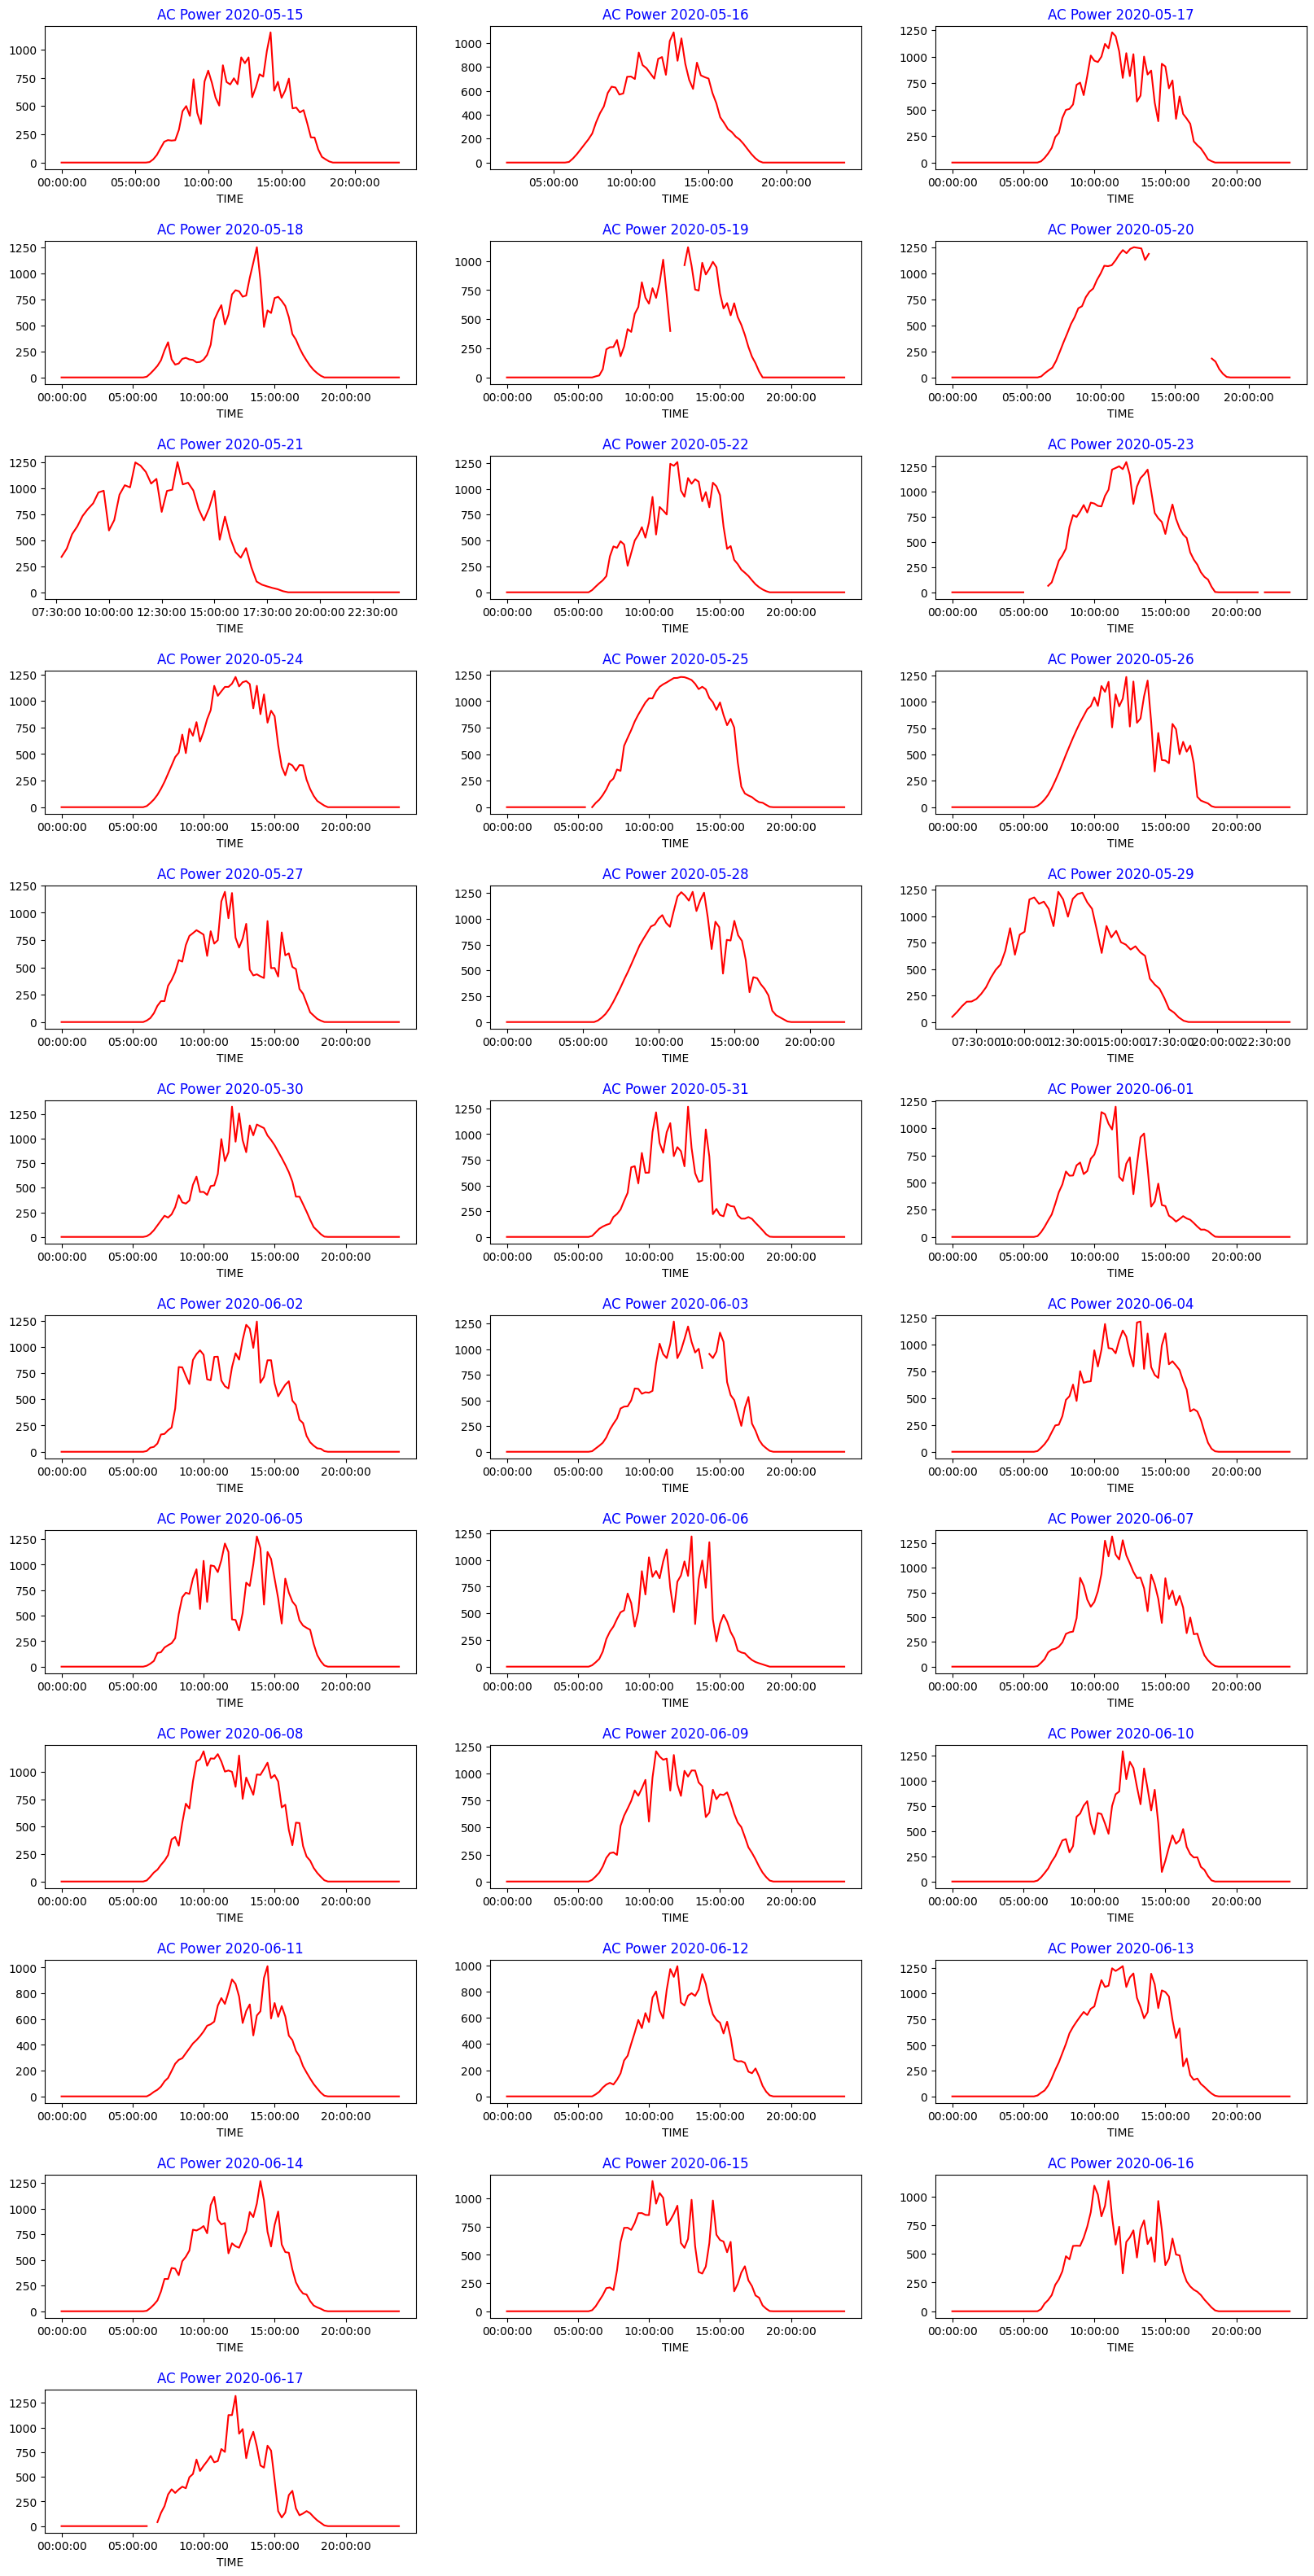

In [23]:
solar_ac = df_solar.pivot_table(values='AC_POWER', index='TIME', columns='DATE')

def Daywise_plot_ac(data= None, row = None, col = None, title='AC Power'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot_ac(data=solar_ac, row=12, col=3)

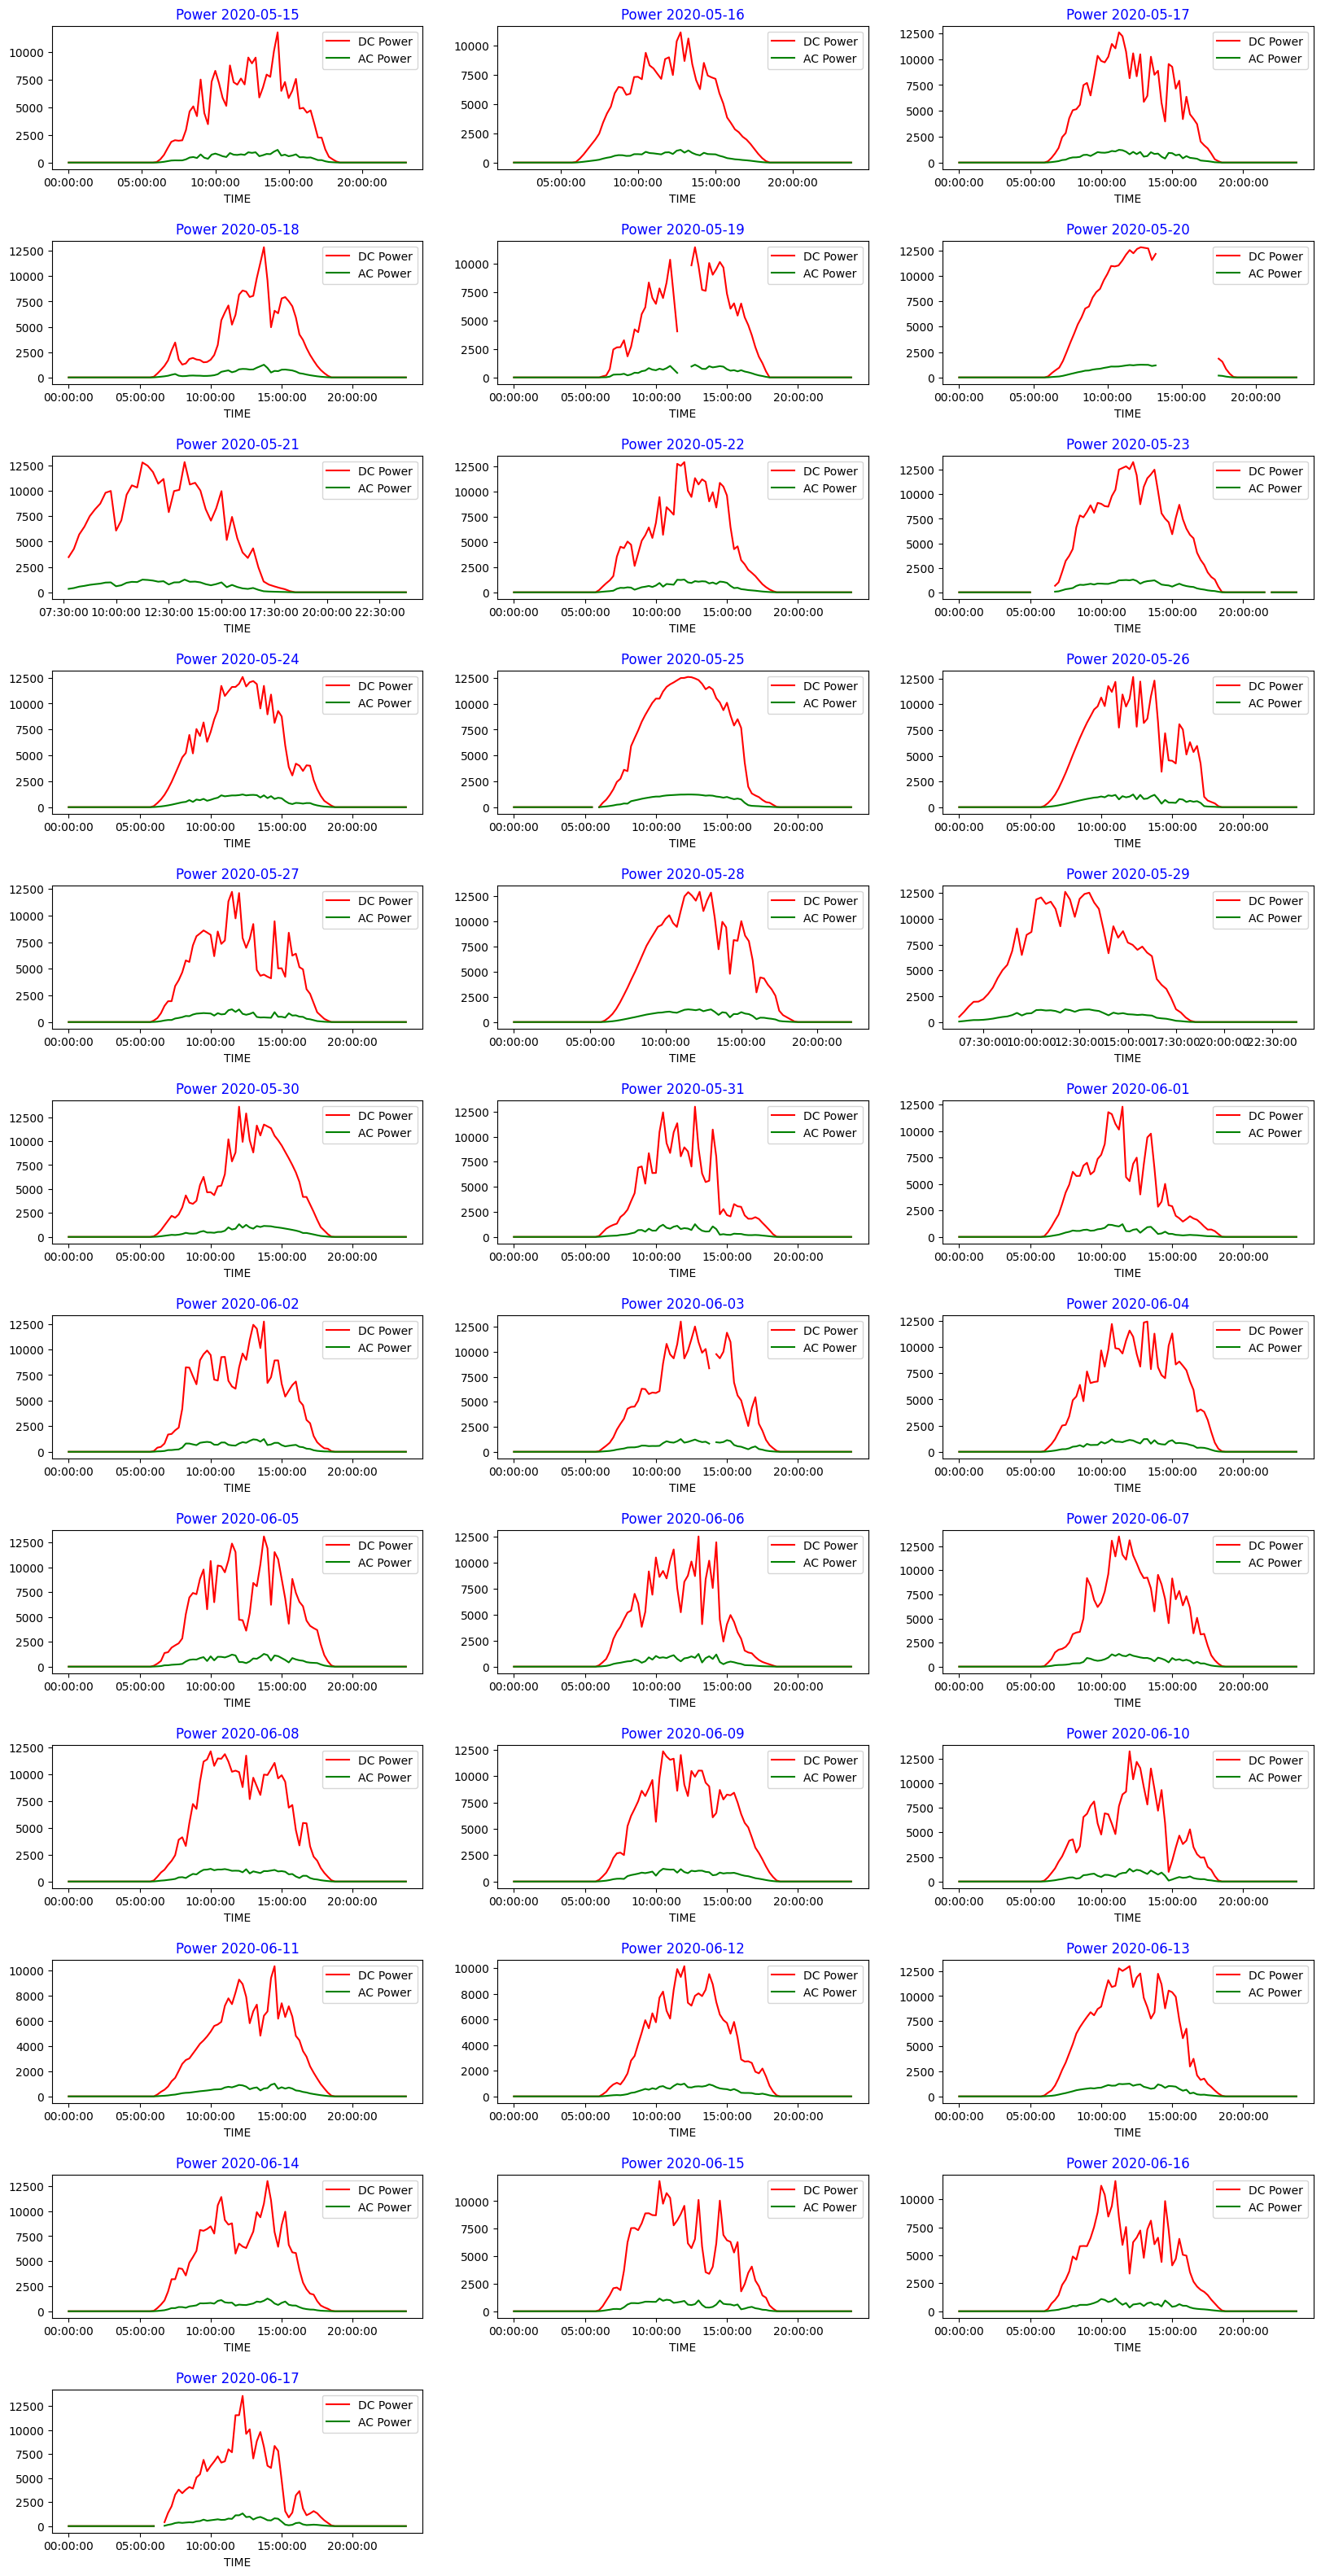

In [24]:

def Daywise_plot_dc_ac(dc_data=None, ac_data=None, row=None, col=None, title='Power'):
    cols = dc_data.columns  # take all columns
    gp = plt.figure(figsize=(20, 40)) 
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='red', label='DC Power')
        ac_data[cols[i - 1]].plot(ax=ax, color='green', label='AC Power')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='blue')
        ax.legend()

Daywise_plot_dc_ac(dc_data=solar_dc, ac_data=solar_ac, row=12, col=3)

# Observations:
###  DC Low Fluctuations: 2020-05-16, 2020-05-24, 2020-05-25, 2020-06-04
### DC High Fluctuations: 2020-05-15, 2020-05-17, 2020-05-21, 2020-05-26, 2020-05-27, 2020-06-09, 2020-06-08, 2020-06-11, 2020-06-12, 2020-06-13
### DC Very High Fluctuations: 2020-05-19, 2020-05-20, 2020-05-31, 2020-06-05, 2020-06-06, 2020-06-17 

### We can see that AC Power follows the same trend as DC Power because it is generated by DC power but it is 1/10th of the DC Power

## 2. DC Power & AC Power generated per day, sorted by descending order

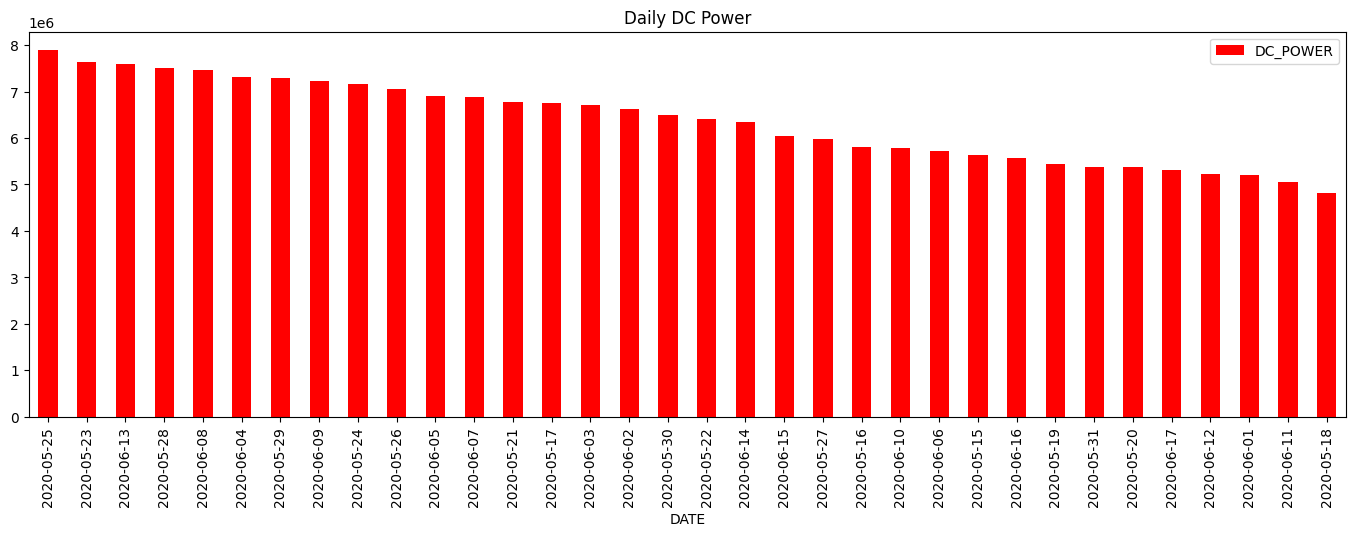

In [25]:
daily_dc = df_solar.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily DC Power')
plt.show()

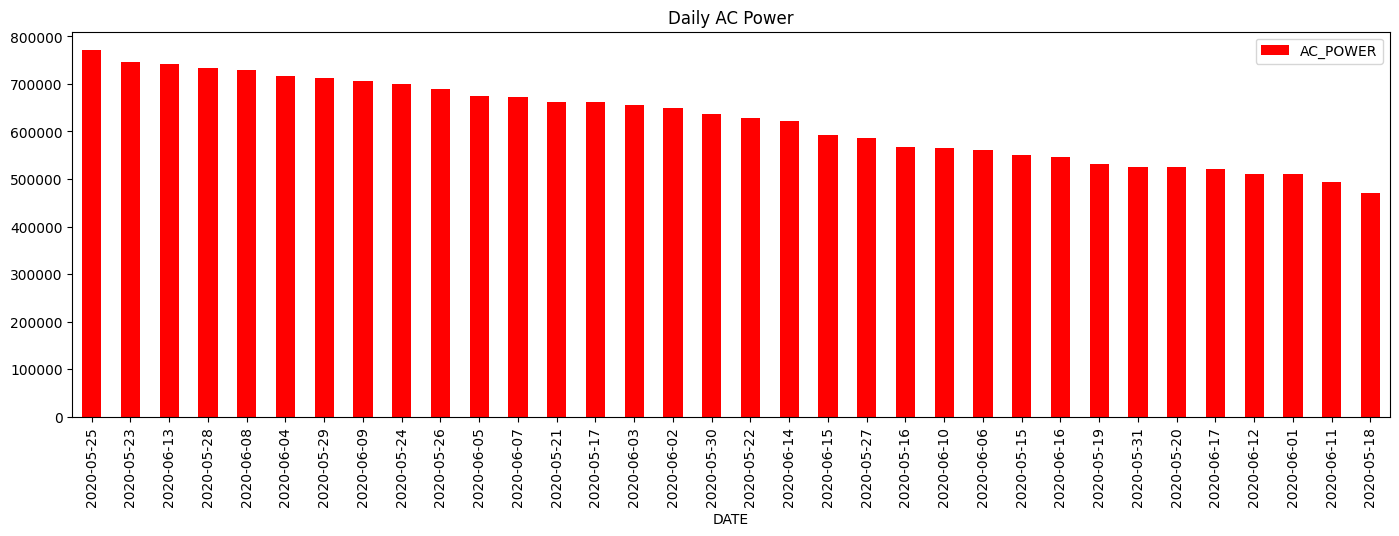

In [26]:
daily_ac = df_solar.groupby('DATE')['AC_POWER'].agg('sum')

ax = daily_ac.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily AC Power')
plt.show()

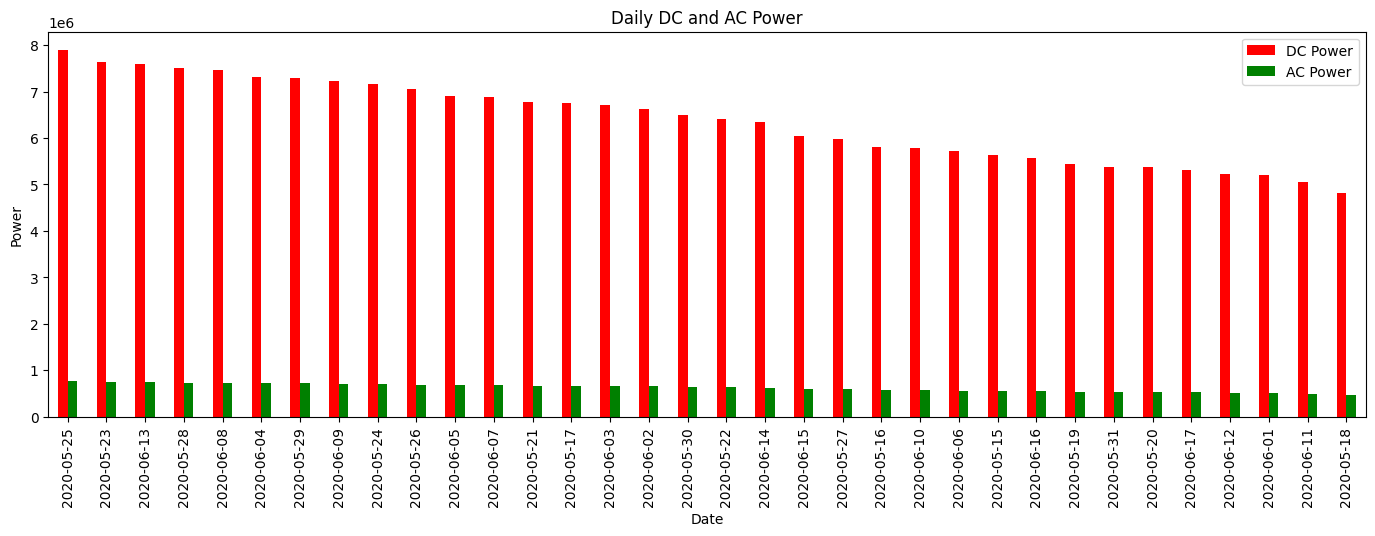

In [27]:

# Combine both daily sums into a single DataFrame
daily_power = pd.DataFrame({'DC_POWER': daily_dc, 'AC_POWER': daily_ac})

# Plot the grouped bar plot
ax = daily_power.sort_values(by='DC_POWER', ascending=False).plot.bar(
    figsize=(17, 5), color=['red', 'green']
)
plt.title('Daily DC and AC Power')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend(['DC Power', 'AC Power'])
plt.show()


## Observations:

### Highest DC_POWER Generation is on: 2020-05-25
### Lowest DC_POWER Generation is on : 2020-05-18

## 3. Irradiation Plots over all 34 days

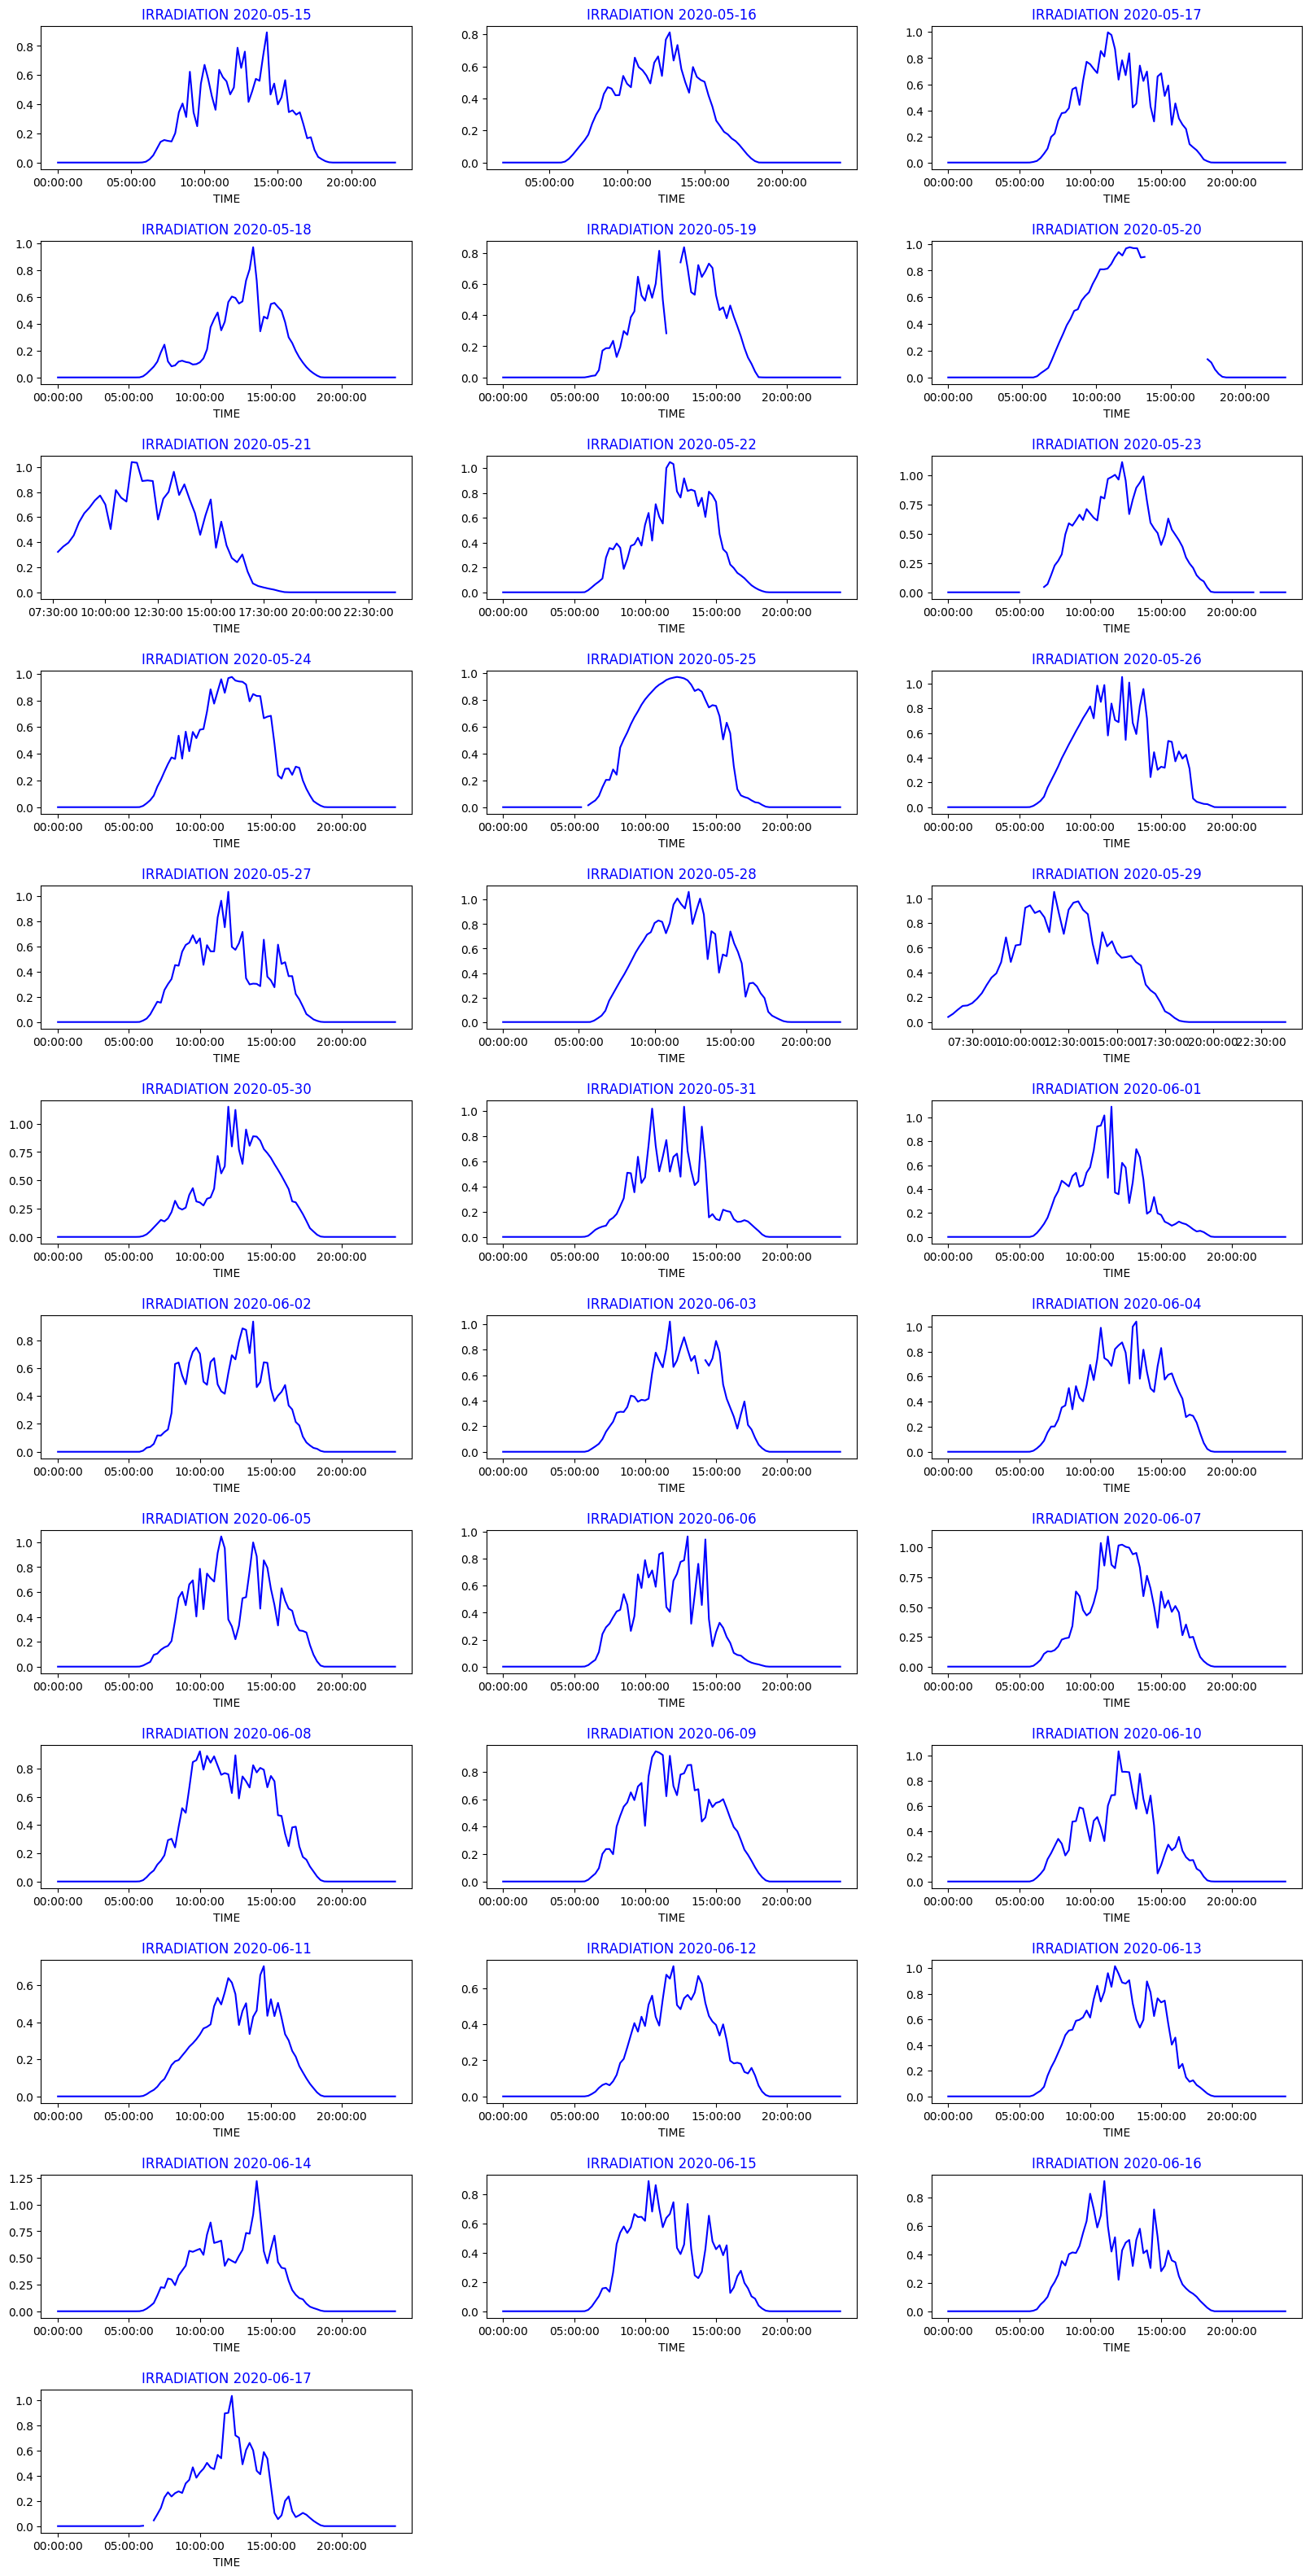

In [28]:
solar_irradiation = df_solar.pivot_table(values='IRRADIATION', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='blue')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')
        
Daywise_plot(data=solar_irradiation, row=12, col=3)


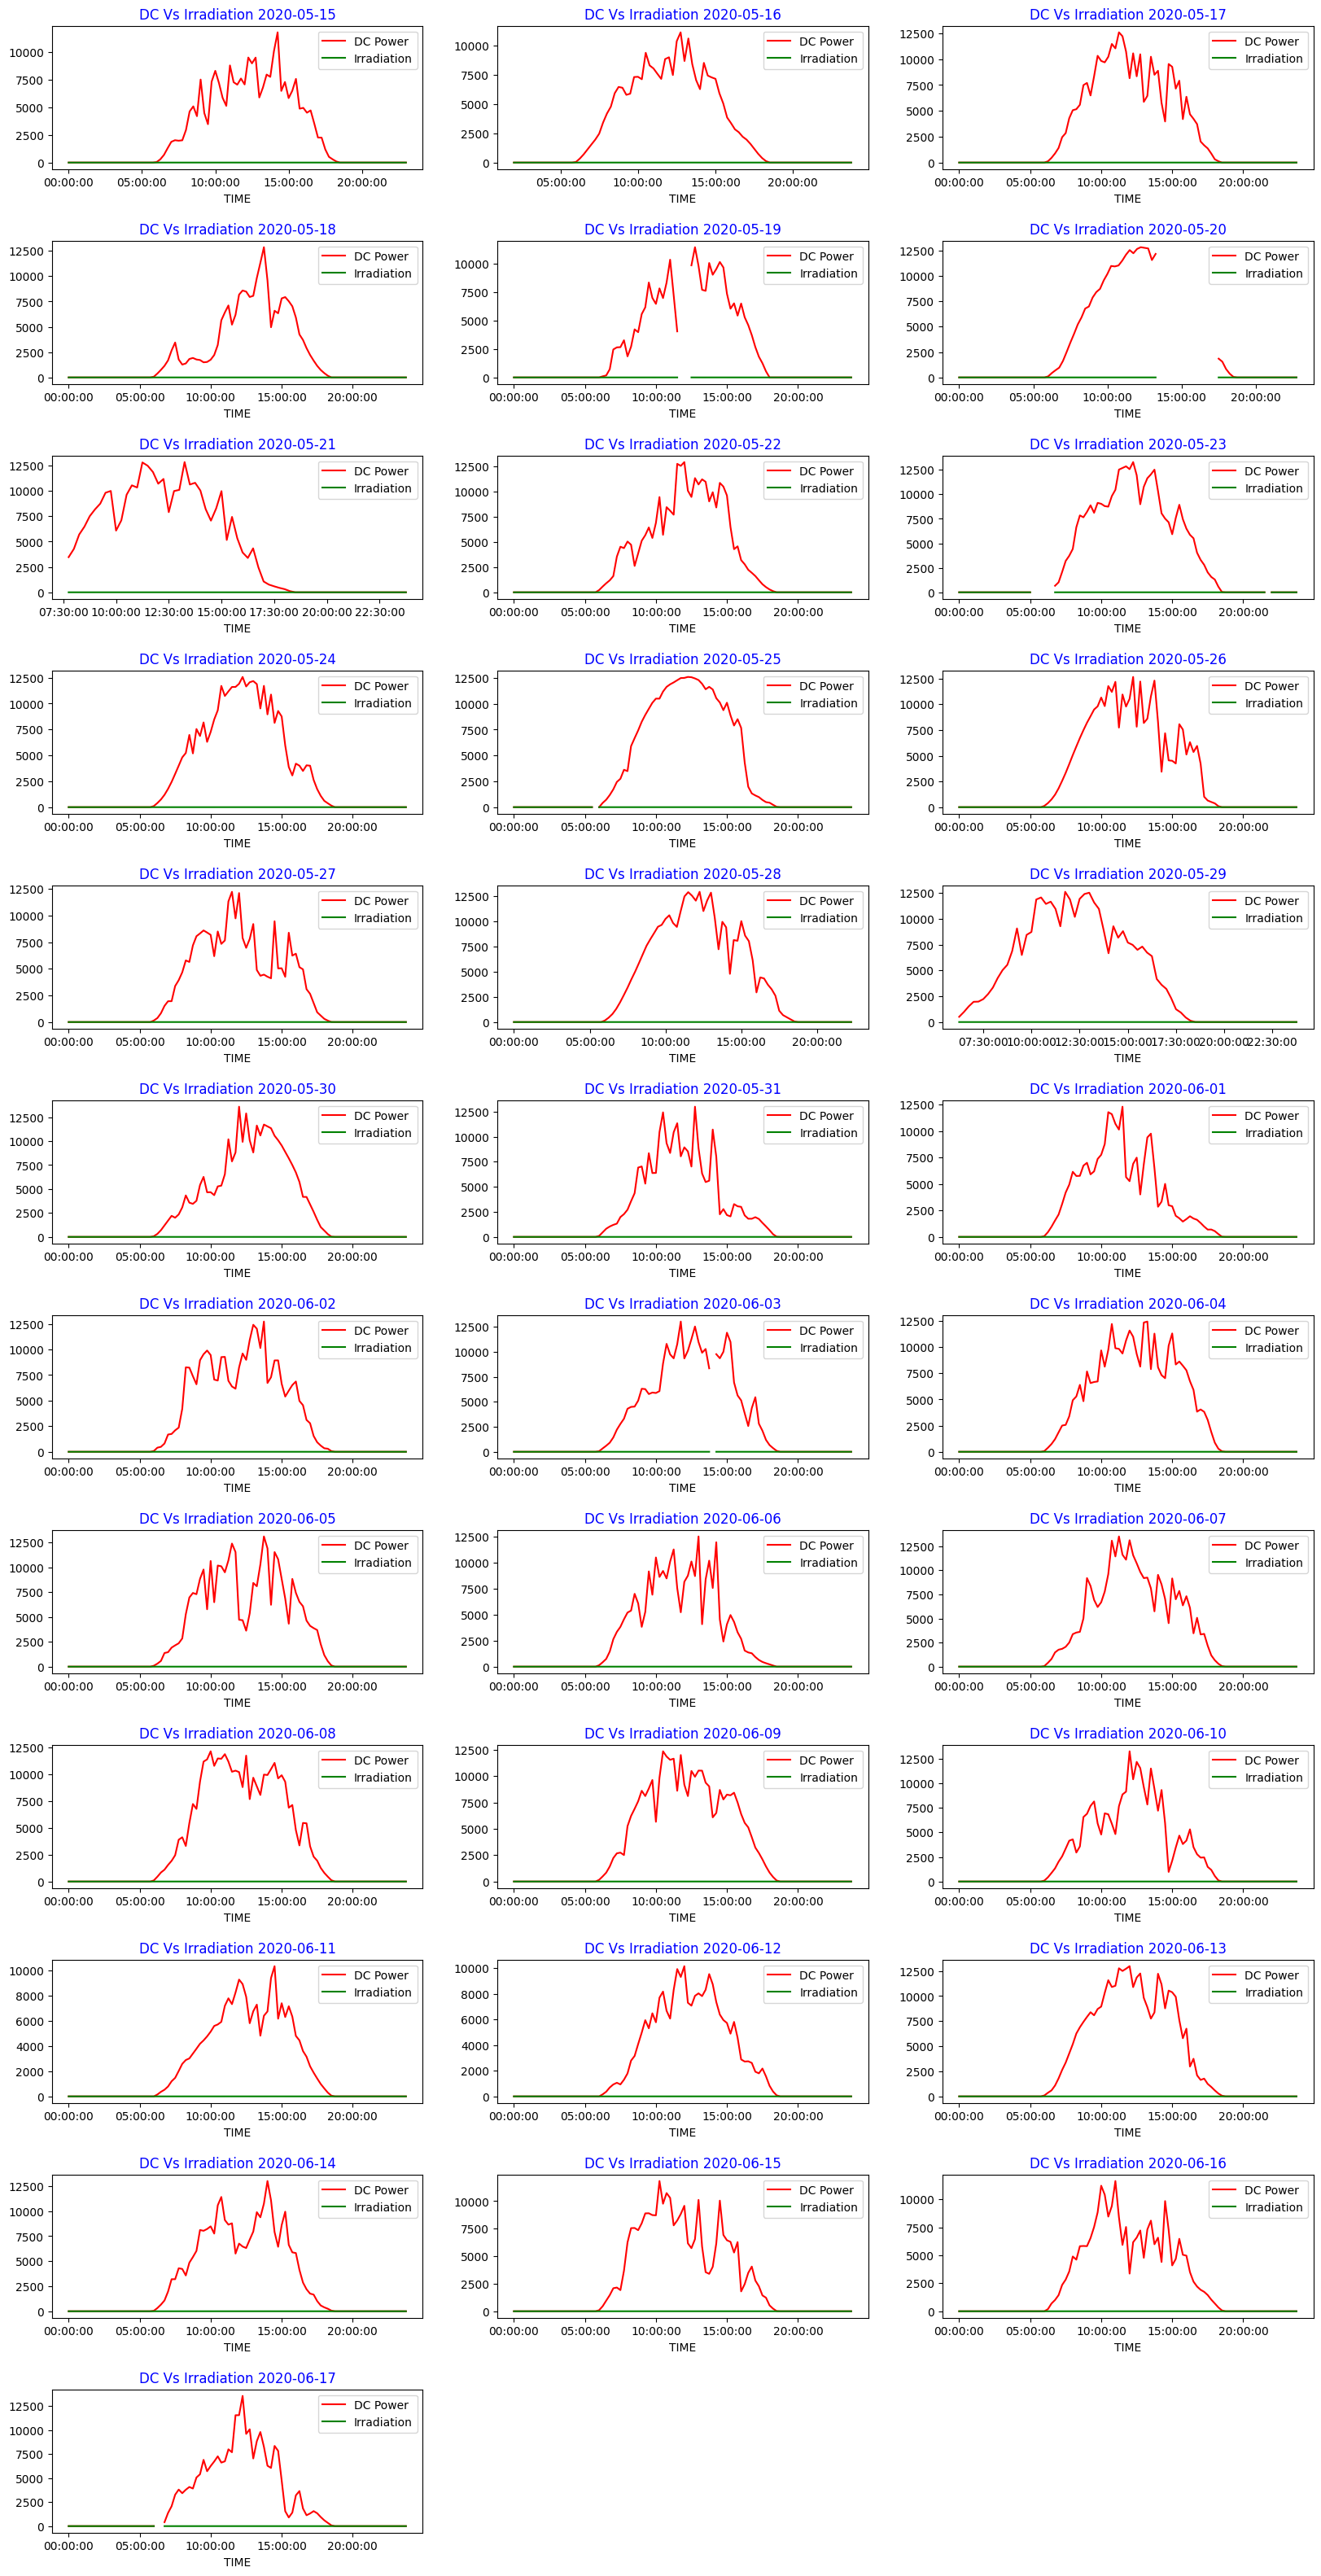

In [29]:

def Daywise_plot_dc_irradiation(dc_data=None, irrad_data=None, row=None, col=None, title='DC Vs Irradiation'):
    cols = dc_data.columns  # take all columns
    gp = plt.figure(figsize=(20, 40)) 
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='red', label='DC Power')
        irrad_data[cols[i - 1]].plot(ax=ax, color='green', label='Irradiation')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='blue')
        ax.legend()

Daywise_plot_dc_irradiation(dc_data=solar_dc, irrad_data=solar_irradiation, row=12, col=3)

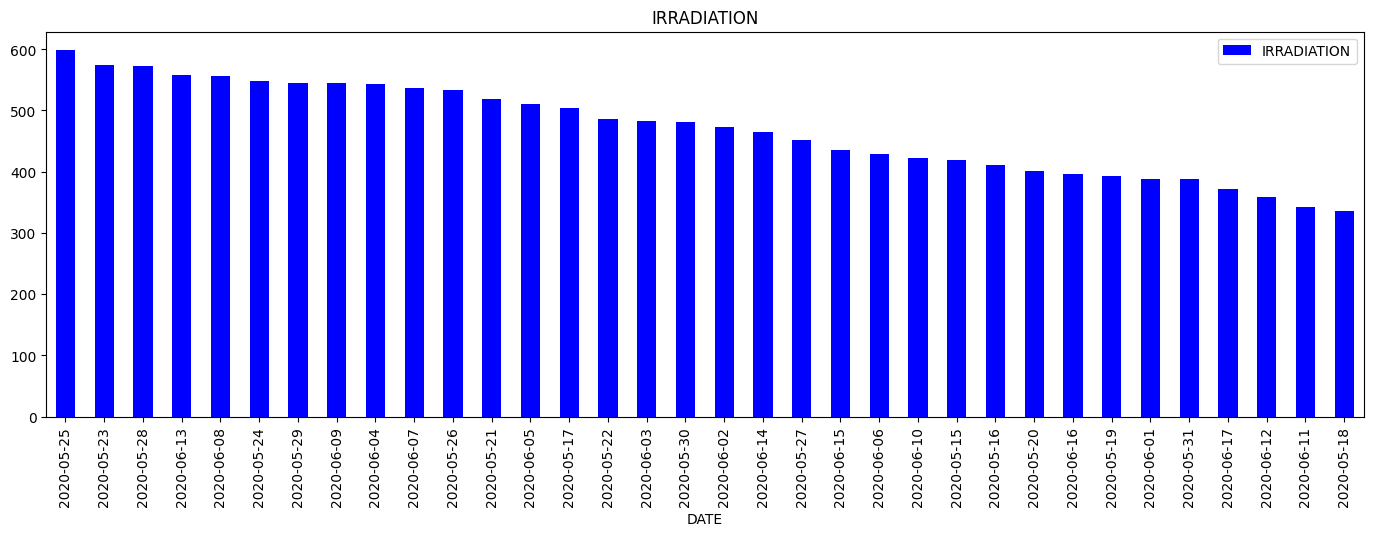

In [30]:

daily_irradiation = df_solar.groupby('DATE')['IRRADIATION'].agg('sum')

daily_irradiation.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='blue')
plt.title('IRRADIATION')
plt.show()


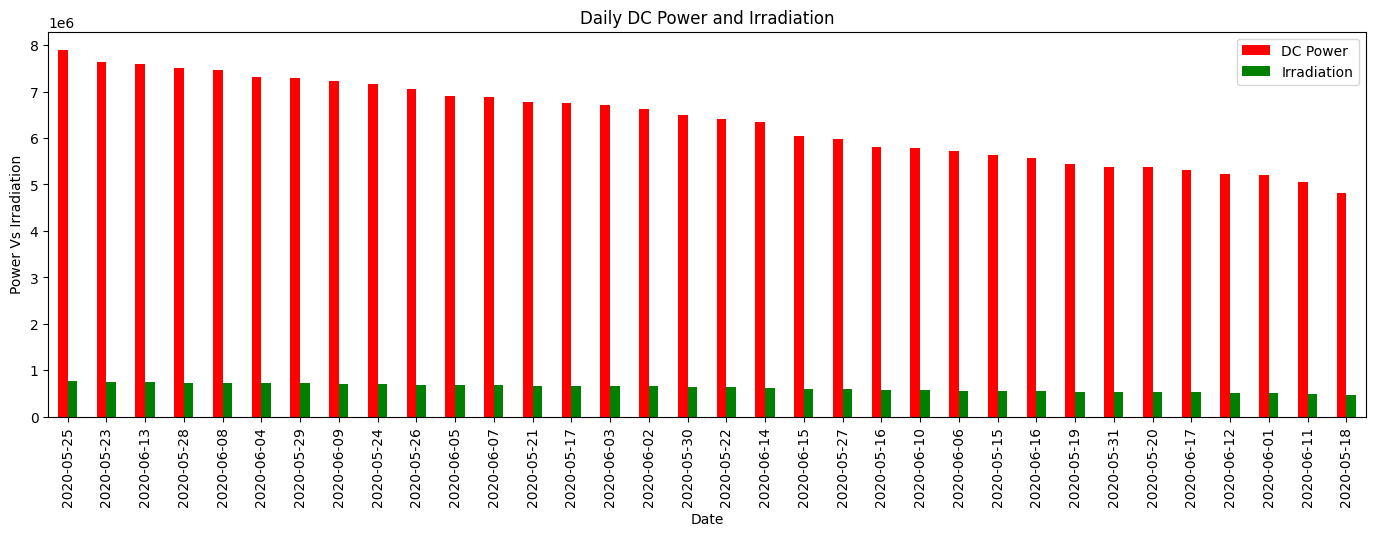

In [31]:
# Combine both daily sums into a single DataFrame
daily_dcpower_irrad = pd.DataFrame({'DC_POWER': daily_dc, 'IRRADIATION': daily_irradiation})

# Plot the grouped bar plot
ax = daily_power.sort_values(by='DC_POWER', ascending=False).plot.bar(
    figsize=(17, 5), color=['red', 'green']
)
plt.title('Daily DC Power and Irradiation')
plt.xlabel('Date')
plt.ylabel('Power Vs Irradiation')
plt.legend(['DC Power', 'Irradiation'])
plt.show()


## Observations:

### Highest Irradiation is on: 2020-05-25
### Lowest Irradiation is on : 2020-06-18
### these graphs are similar to DC_Output graphs because irradiation is the amount of sunlight that falls on unit m2. this is directly proportional to the dc output produced. Huge amounts of DC power is generated with very little irradiation

# 4. Ambient & Module Temperature plots

In [32]:
#sns.displot(data=df_solar, x="AMBIENT_TEMPERATURE", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

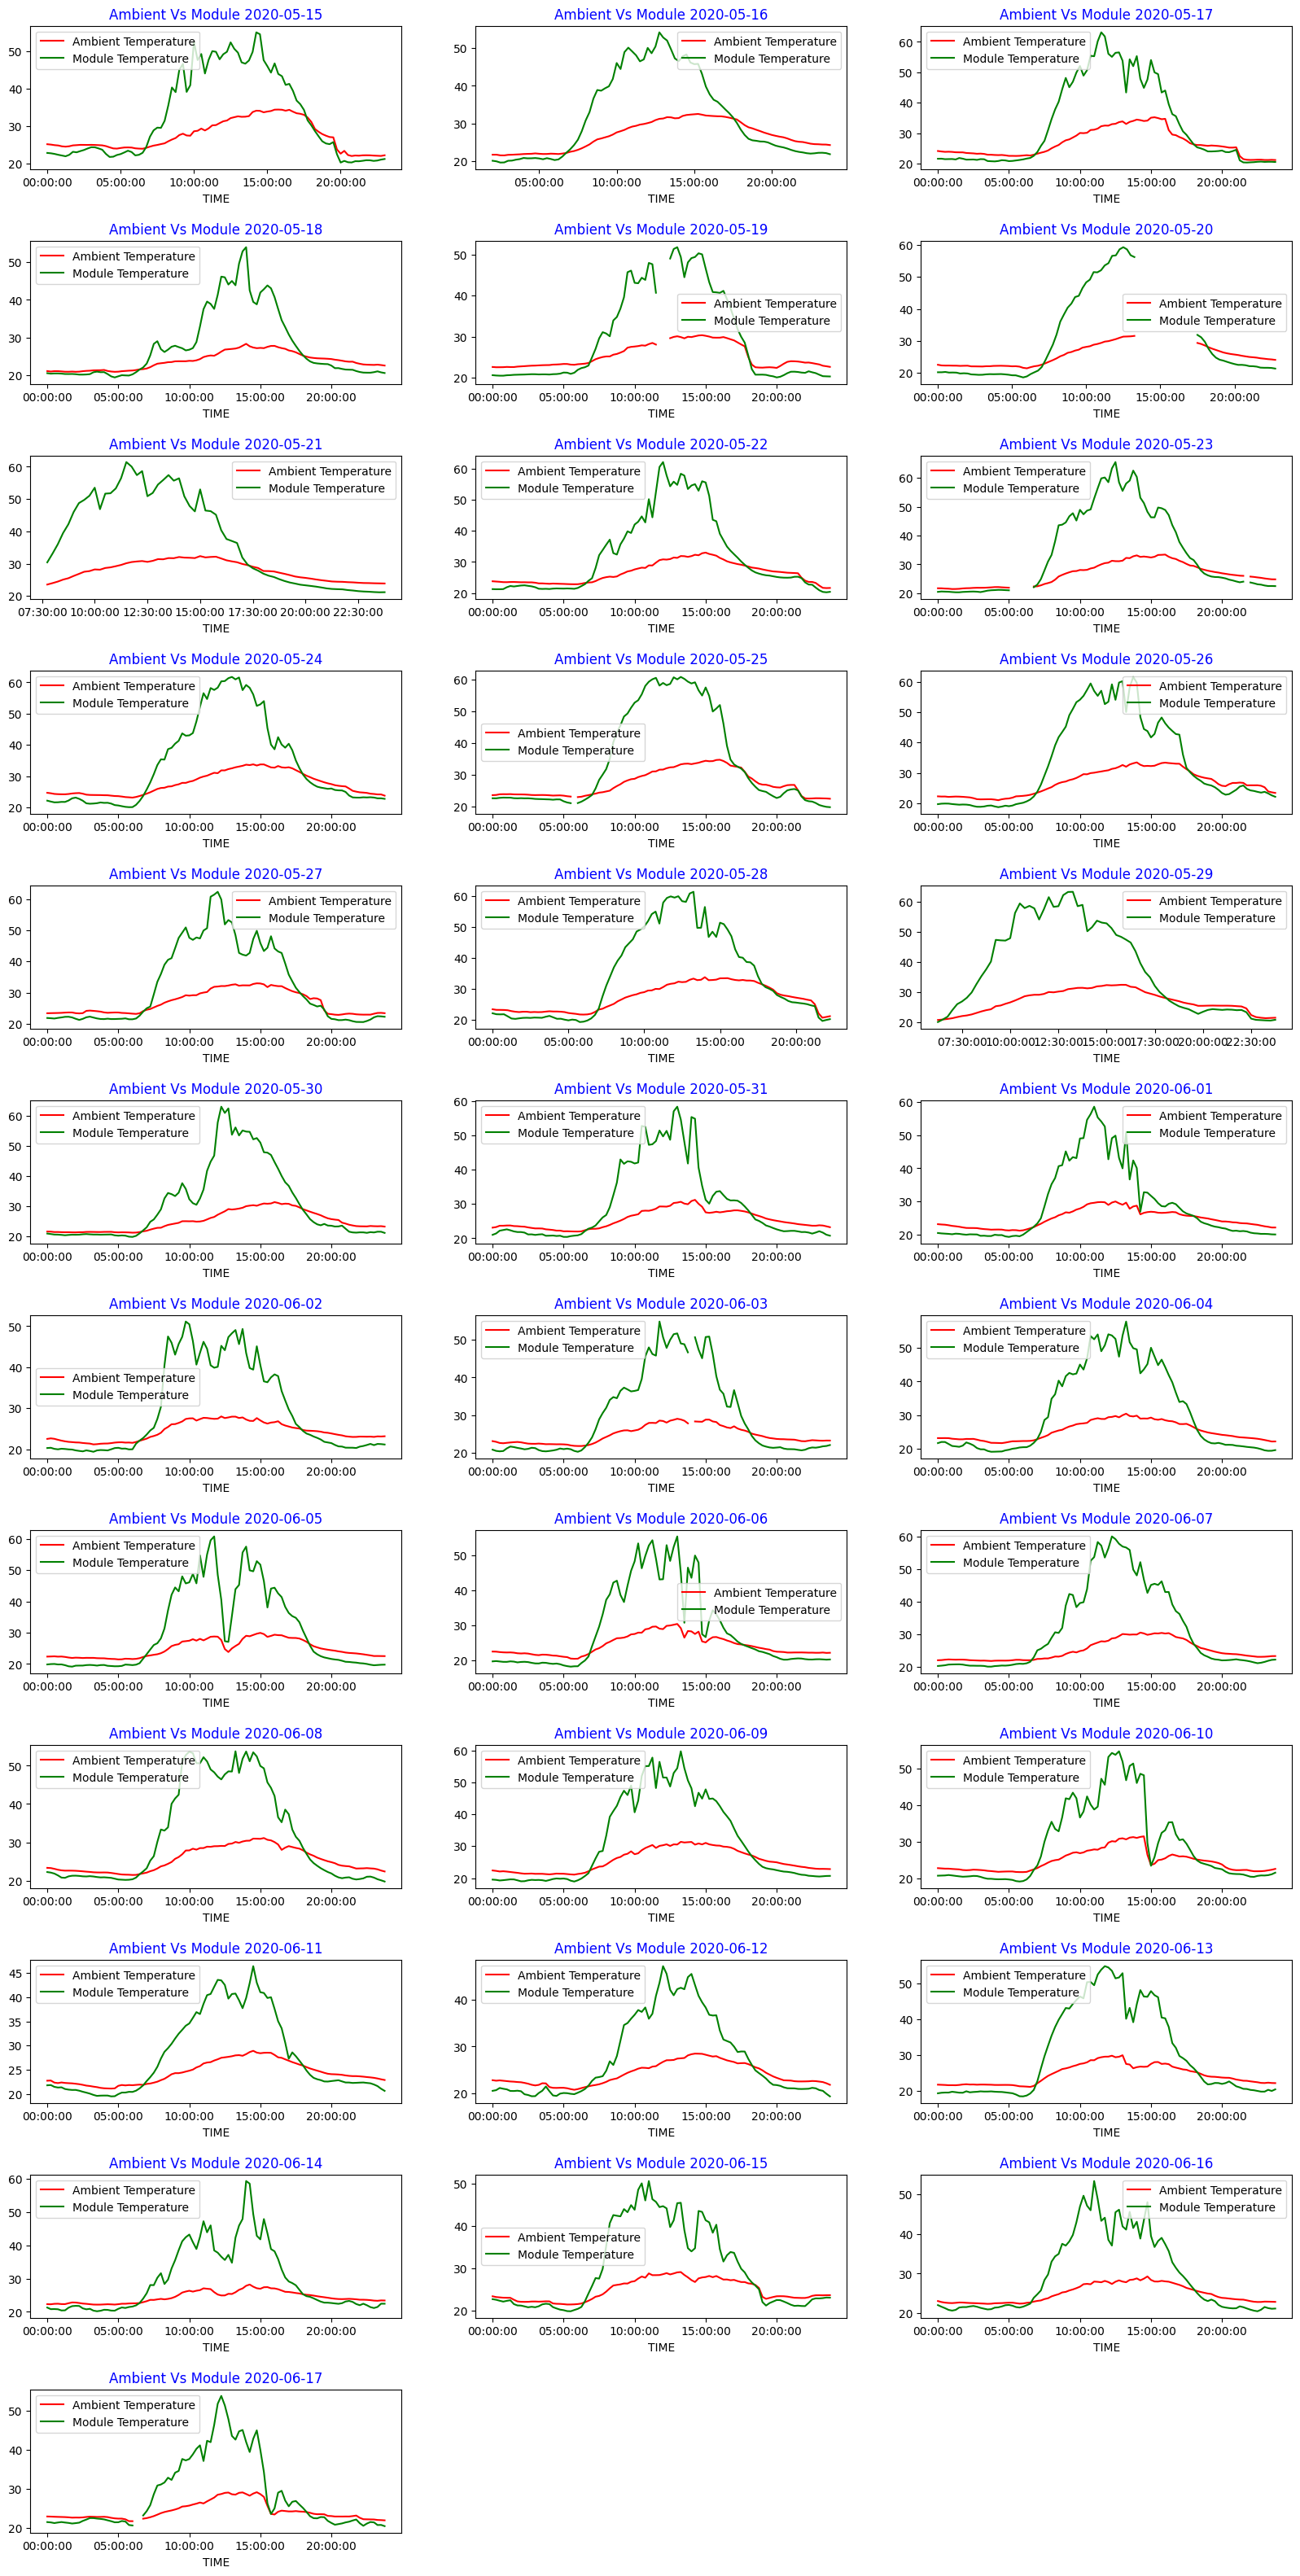

In [33]:
solar_ambiant_temp = df_solar.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')
solar_module_temp = df_solar.pivot_table(values='MODULE_TEMPERATURE', index='TIME', columns='DATE')

def Daywise_plot_am_mo(am_data=None, mo_data=None, row=None, col=None, title='Ambient Vs Module'):
    cols = am_data.columns  # take all columns
    gp = plt.figure(figsize=(20, 40)) 
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        am_data[cols[i - 1]].plot(ax=ax, color='red', label='Ambient Temperature')
        mo_data[cols[i - 1]].plot(ax=ax, color='green', label='Module Temperature')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='blue')
        ax.legend()

Daywise_plot_am_mo(am_data=solar_ambiant_temp, mo_data=solar_module_temp, row=12, col=3)

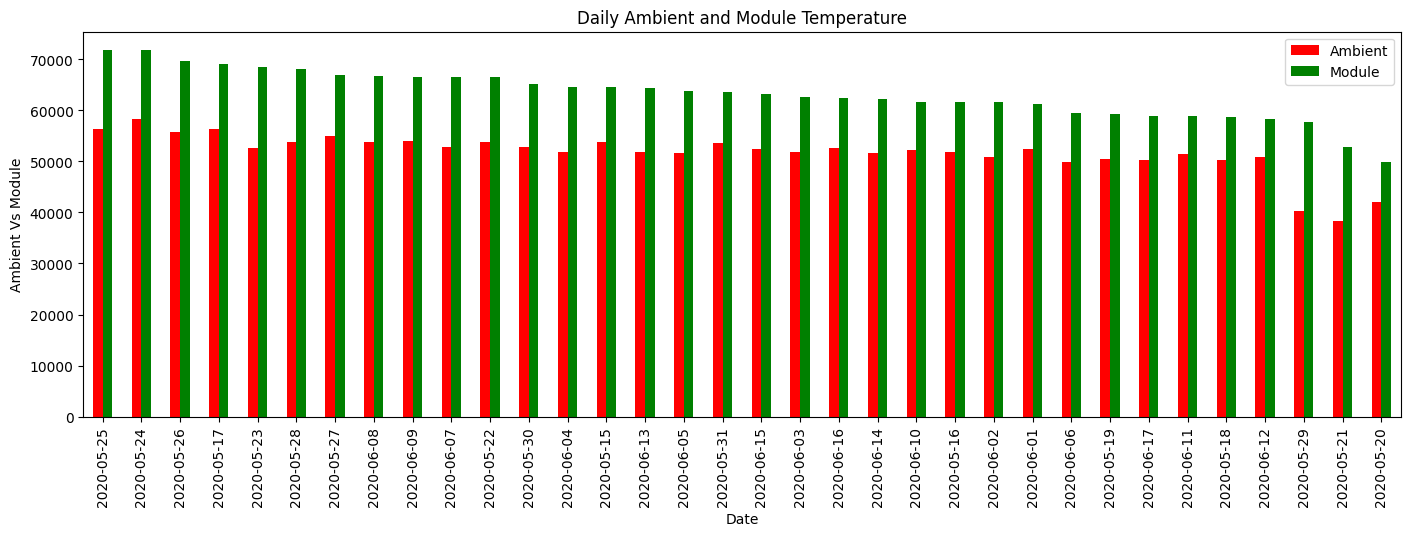

In [34]:
daily_am = df_solar.groupby('DATE')['AMBIENT_TEMPERATURE'].agg('sum')
daily_mo = df_solar.groupby('DATE')['MODULE_TEMPERATURE'].agg('sum')

#daily_ambient_temp.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkgreen')
#plt.title('AMBIENT_TEMPERATURE')
#plt.show()

daily_ambient_module_temp = pd.DataFrame({'AMBIENT_TEMPERATURE': daily_am, 'MODULE_TEMPERATURE': daily_mo})

# Plot the grouped bar plot
ax = daily_ambient_module_temp.sort_values(by='MODULE_TEMPERATURE', ascending=False).plot.bar(
    figsize=(17, 5), color=['red', 'green']
)
plt.title('Daily Ambient and Module Temperature')
plt.xlabel('Date')
plt.ylabel('Ambient Vs Module')
plt.legend(['Ambient', 'Module'])
plt.show()


# Observation: 

## Module temperature is much higher than Ambient Temperature so probably Module temperature is not highly influenced by Ambient Temperature

# 5. DC Power /AC Power/ Irradiation / Ambient Vs Module Temperature

## Highest DC_POWER is generated on "2020-05-25"

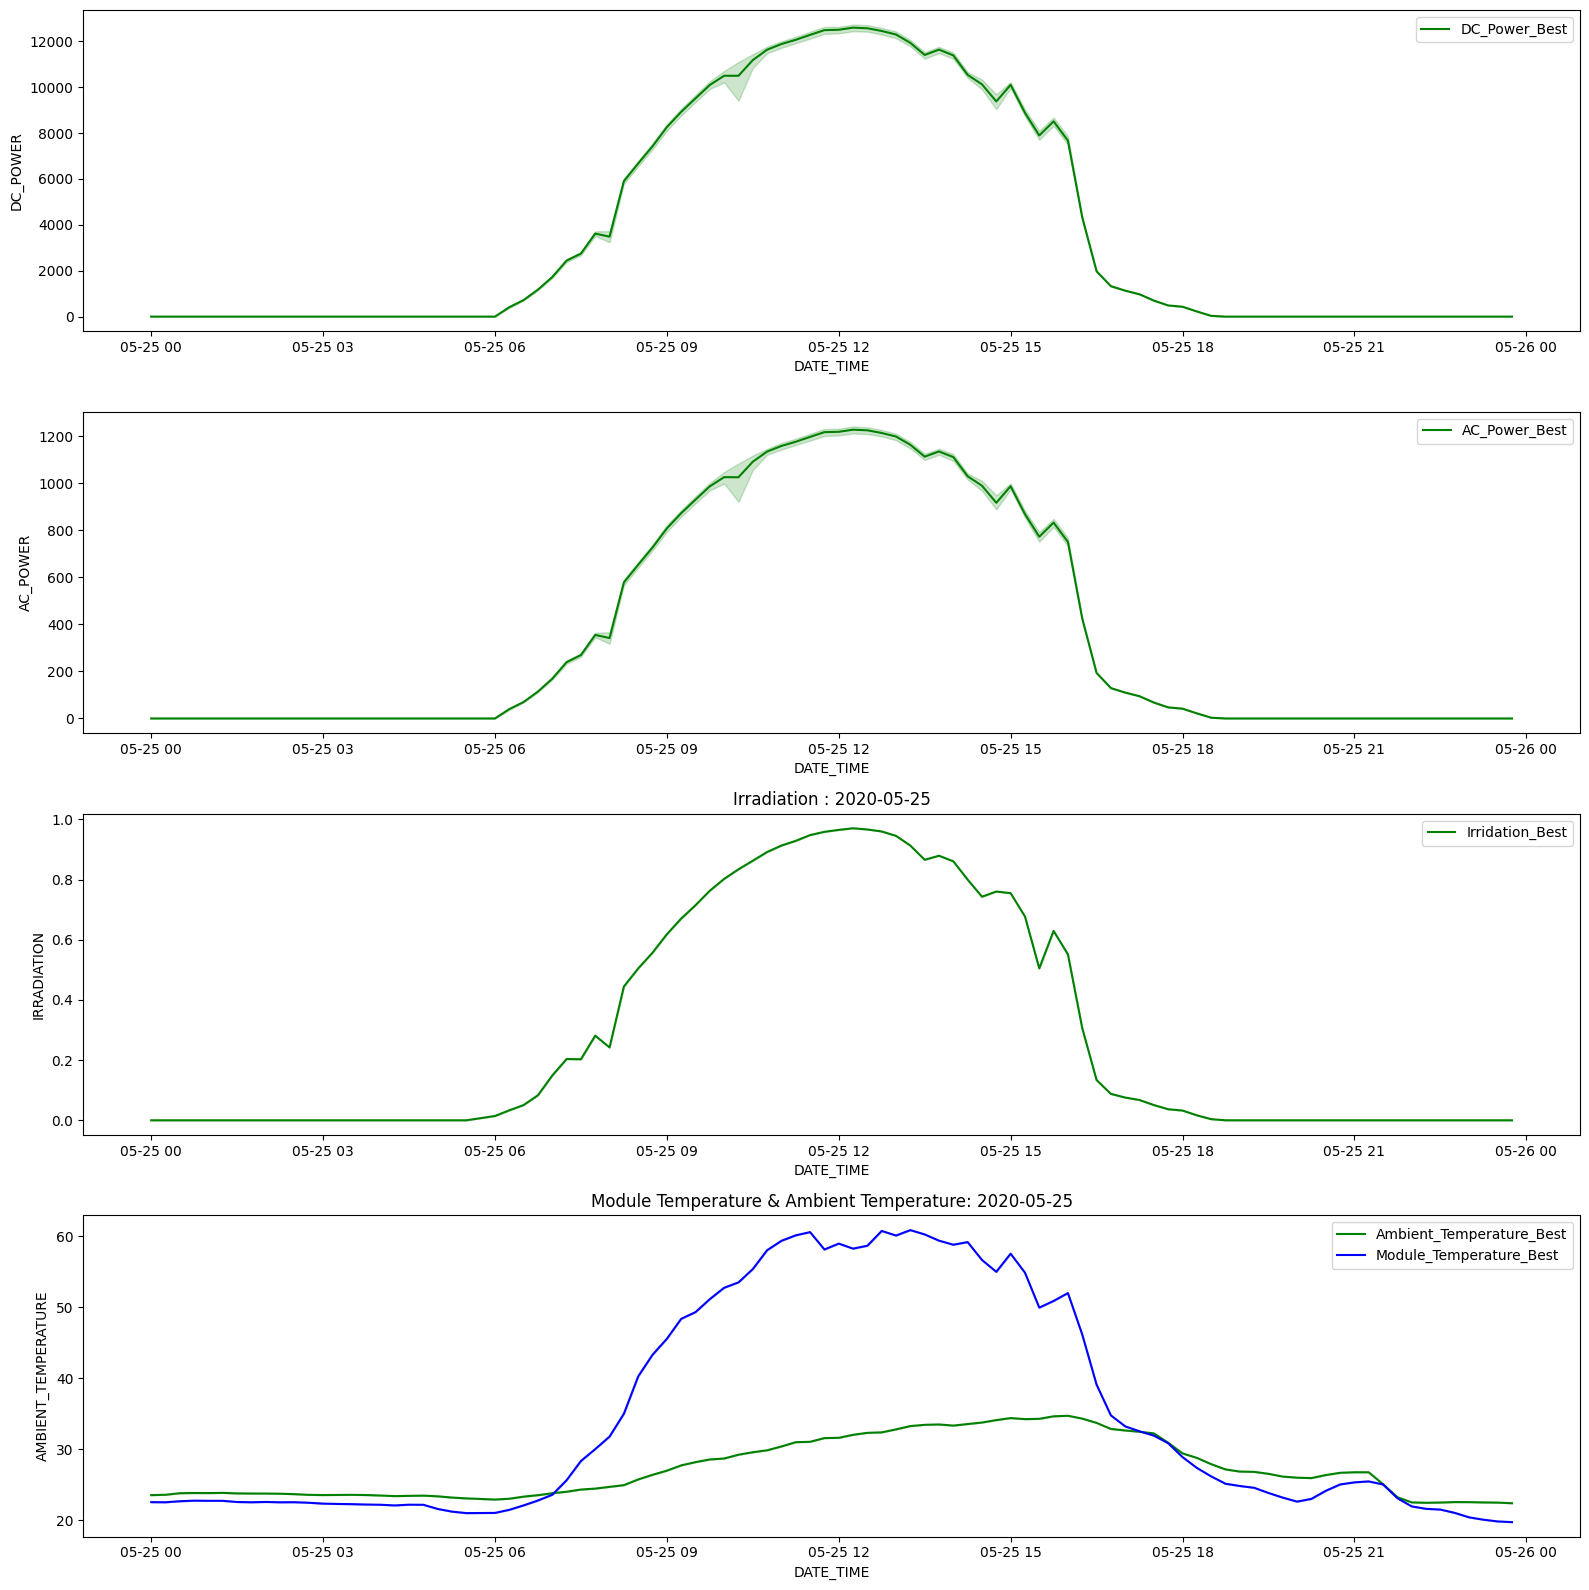

In [35]:
plt.figure(figsize=(16,16))

date=["2020-05-25"]

plt.subplot(411)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME,
             y=df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER,
             label="DC_Power_Best",
             color='green')

plt.subplot(412)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME,
             y=df_solar[df_solar["DATE_STRING"].isin(date)].AC_POWER,
             label="AC_Power_Best",
             color='green')

plt.subplot(413)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, 
             label="Irridation_Best",
             color='green');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(414)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, 
             label="Ambient_Temperature_Best",
             color='green');
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, 
             label="Module_Temperature_Best",
             color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

### NOTE: Both DC_POWER graph and IRRADIATION graph is almost looking like an ideal graph which is explained earlier. Weather is also looking good, and there is no cloud is in the sky because there is very less variation in IRRADIATION and temperature of the solar panel and ambient temperature.



## Lowest average DC_POWER is generated on "2020-05-18"

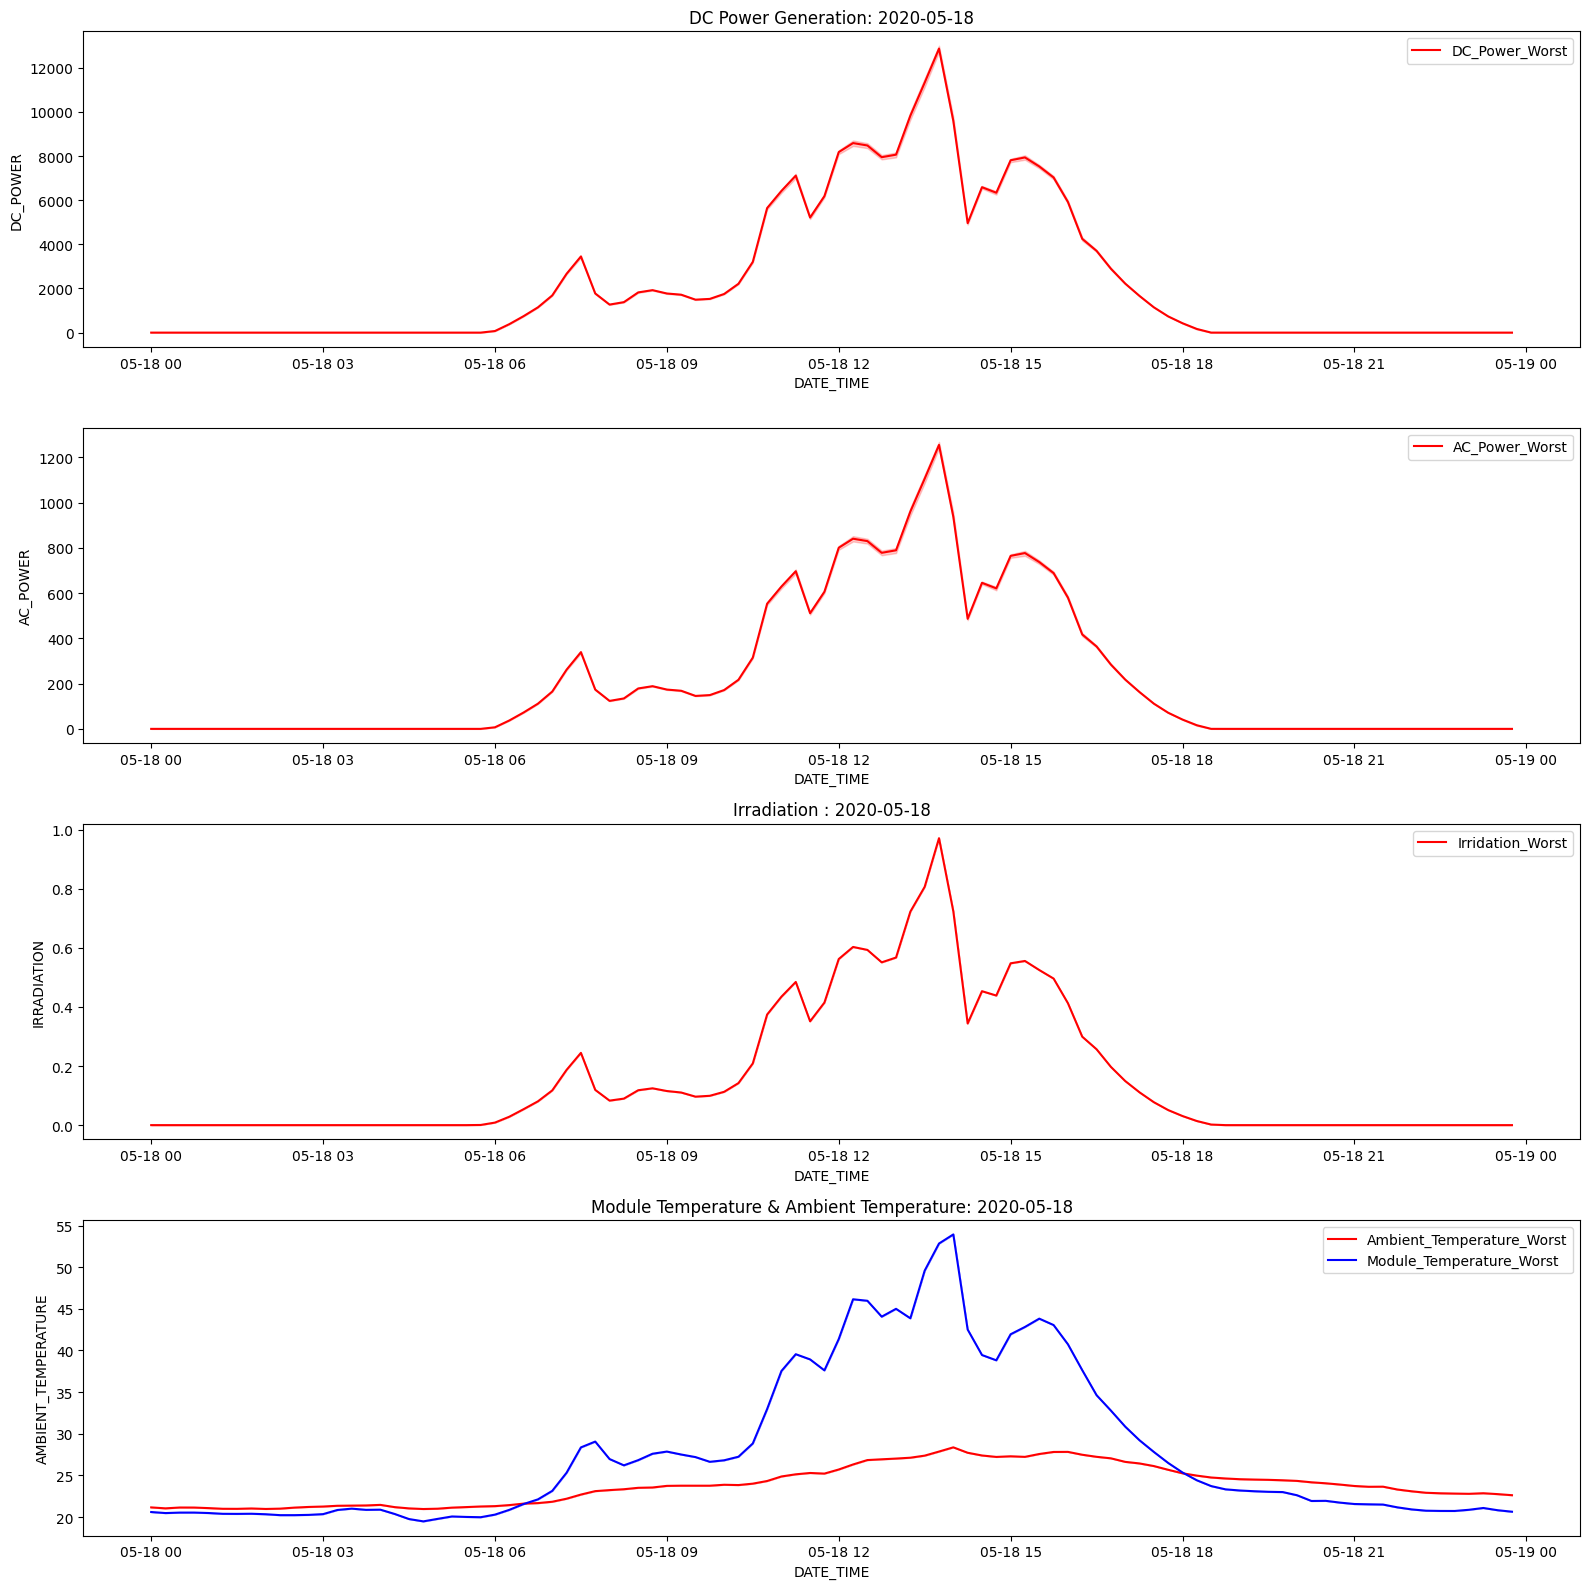

In [36]:
date=["2020-05-18"]
plt.figure(figsize=(16,16))

plt.subplot(411)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, 
             label="DC_Power_Worst",
             color='red');
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME,
             y=df_solar[df_solar["DATE_STRING"].isin(date)].AC_POWER,
             label="AC_Power_Worst",
             color='red')


plt.subplot(413)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, 
             label="Irridation_Worst",
             color='red');
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(414)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, 
             label="Ambient_Temperature_Worst",
             color='red');
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, 
             y=df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, 
             label="Module_Temperature_Worst",
             color='blue');
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]));

plt.tight_layout()
plt.show()

# 6. AC Power vs Inverter Plot for a particular date and time

In [37]:
df_solar['SOURCE_KEY'].unique()

array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'ZnxXDlPa8U1GXgE', 'ZoEaEvLYb1n2sOq',
       'adLQvlD726eNBSB', 'bvBOhCH3iADSZry', 'iCRJl6heRkivqQ3',
       'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj', 'rGa61gmuvPhdLxV',
       'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc', 'wCURE6d3bPkepu2',
       'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY', 'zVJPv84UY57bAof',
       'YxYtjZvoooNbGkE'], dtype=object)

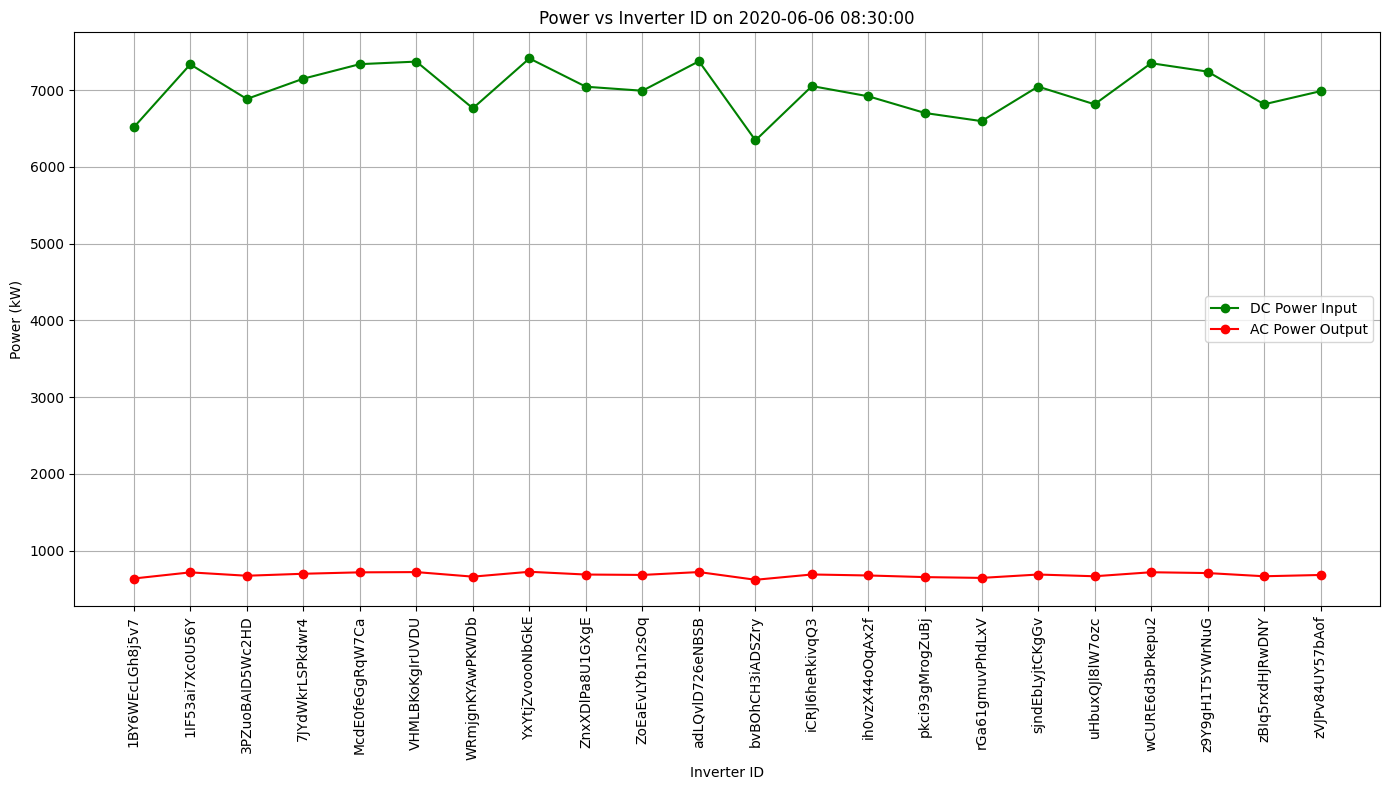

In [38]:
filter_date = '2020-06-06 08:30:00'

filtered_df = df_solar[df_solar['DATE_TIME'] == filter_date]

# Create the plot
plt.figure(figsize=(14, 8))

# Plotting DC Power Output
plt.plot(filtered_df['SOURCE_KEY'], filtered_df['DC_POWER'], marker='o', linestyle='-', color='g', label='DC Power Input')

# Plotting AC Power Output
plt.plot(filtered_df['SOURCE_KEY'], filtered_df['AC_POWER'], marker='o', linestyle='-', color='r', label='AC Power Output')

# Adding title and labels
plt.title(f'Power vs Inverter ID on {filter_date}')
plt.xlabel('Inverter ID')
plt.ylabel('Power (kW)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Observation:

## Here we can see that every inverter performs badly in converting DC to AC power efficiently.

# Solar Power Plant Inverter Efficiency Calculation

In [39]:
solar_dc_power = df_solar[df_solar['DC_POWER'] > 0]['DC_POWER'].values
solar_ac_power = df_solar[df_solar['AC_POWER'] > 0]['AC_POWER'].values

In [40]:
solar_plant_eff = (np.max(solar_ac_power)/np.max(solar_dc_power ))*100
print(f"Power ratio AC/DC (Efficiency) of Solar Power Plant:  {solar_plant_eff:0.3f} %")

Power ratio AC/DC (Efficiency) of Solar Power Plant:  9.750 %


# Observation:

## The efficiency of the plant is very poor. This is likely due to the fact that DC power is not getting converted to AC Power efficiently.

In [41]:
AC_list=[]
for i in df_solar['AC_POWER']:
    if i>0:
        AC_list.append(i)
AC_list
#AC_list.sort()
#AC_list.reverse()
len(AC_list)

36823

In [42]:
DC_list=[]
for i in df_solar['DC_POWER']:
    if i>0:
        DC_list.append(i)
DC_list
DC_list.sort()
DC_list.reverse()
len(DC_list)

36823

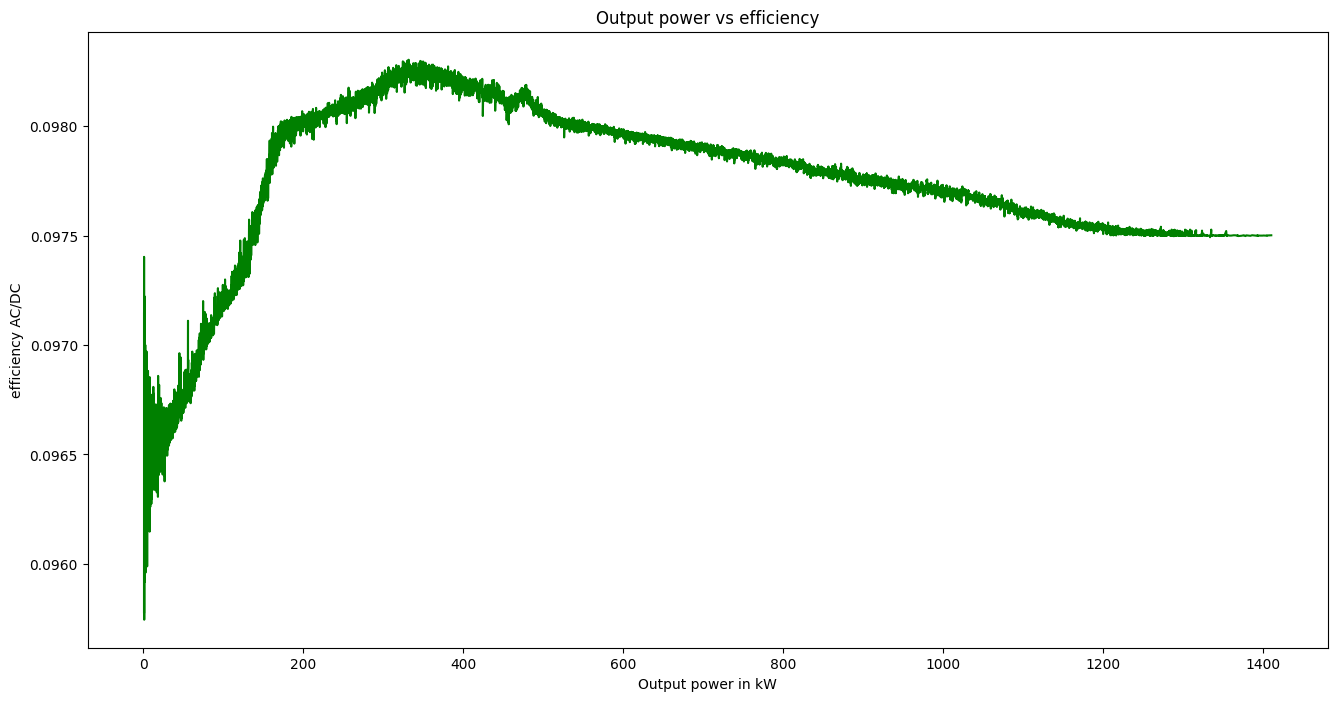

In [43]:
plt.figure(figsize=(16,8))
AC_list.sort()
DC_list.sort()
#print(DC_list)
#DC_list.sort
#res = [i / 10 for i in AC_list]
eff = [i/j for i,j in zip(AC_list,DC_list)]

plt.plot(AC_list,eff,color='green')
plt.xlabel('Output power in kW')
plt.ylabel('efficiency AC/DC')
plt.title('Output power vs efficiency');

# Q1. Can we identify the need for panel cleaning/maintenance?

## The Module temperature is usually quite high but is not getting highly influence by the ambient temperature. This has been observed over all 34 days in Plant 2. This can lead to low efficiency. Similar behaviour has not been observed in Plant 1. In Plant 1, the ambient temperature and module temperature values are seen to be similar. The module temperature (actual temperature of the solar panel) being this high can point to cleaning/maintenance requirement.

# Q2. Can we identify faulty or suboptimally performing equipment?

## As we have observed through the AC/DC plots, there is a huge power loss at the inverter level. The AC output is almost 1/10th of the DC input. There is an issue with every inverter because this is the case with every AC observation. This may point to faulty equipment.

# Q3. Can we predict the power generation for the next couple of days?

In [44]:
df2 = df_solar.copy()
X = df2[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]
y = df2['AC_POWER']

In [45]:
X.head()

DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0          0.0    6259559.0            25.184316           22.857507   
1          0.0    6183645.0            25.184316           22.857507   
2          0.0    6987759.0            25.184316           22.857507   
3          0.0    7602960.0            25.184316           22.857507   
4          0.0    7158964.0            25.184316           22.857507   

   IRRADIATION  DC_POWER  
0          0.0       0.0  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4          0.0       0.0

In [46]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: AC_POWER, dtype: float64

In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=21)

# Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
score_lr = 100*lr_clf.score(X_test,y_test)
print(f'LR Model score = {score_lr:4.4f}%')


LR Model score = 99.9995%


In [49]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
R2_Score_lr = round(r2_score(y_pred_lr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_lr,"%")

R2 Score :  100.0 %


# Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_rfr,"%")

R2 Score :  100.0 %


# Decision Tree

In [51]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

y_pred_dtr = rfr.predict(X_test)
R2_Score_dtr = round(r2_score(y_pred_dtr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_dtr,"%")


R2 Score :  100.0 %


# Result predictions

In [52]:
prediction = rfr.predict(X_test)
print(prediction)


[   0.         1071.24303578  299.62135714 ...  669.40498213  377.82001786
  117.4835    ]


In [53]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction})
cross_checking.head()

Actual    Predicted
43819     0.0000     0.000000
2949   1072.3250  1071.243036
33769   299.8125   299.621357
47825     0.0000     0.000000
29370     0.0000     0.000000

In [54]:
cross_checking['Error'] = cross_checking['Actual'] - cross_checking['Predicted']
cross_checking.head()


Actual    Predicted     Error
43819     0.0000     0.000000  0.000000
2949   1072.3250  1071.243036  1.081964
33769   299.8125   299.621357  0.191143
47825     0.0000     0.000000  0.000000
29370     0.0000     0.000000  0.000000

In [55]:
cross_checking_final  = cross_checking[cross_checking['Error'] <= 20]
cross_checking_final.sample(25).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })
 	

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
mlp_model = Sequential()
mlp_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(1))

# Compile the model
mlp_model.compile(loss='mse', optimizer='adam')

# Train the model
mlp_model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=1)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate the model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f'MLP Model - MSE: {mse_mlp}, R2 Score: {r2_mlp}')


Epoch 1/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step - loss: 49272.4258
Epoch 2/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - loss: 17.8594
Epoch 3/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - loss: 1.5824
Epoch 4/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step - loss: 1.3549
Epoch 5/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 1.9260
Epoch 6/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - loss: 0.8639
Epoch 7/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - loss: 1.1559
Epoch 8/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - loss: 1.3298
Epoch 9/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 1.7006
Epoch 10/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 1.3854
Epoch 11/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - loss: 1.3155
Epoch 12/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 0.9738
Epoch 13/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.7780
Epoch 14/50
5502/5502 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 0.9